In [1]:
import sys
sys.dont_write_bytecode = True
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from keras.utils.np_utils import to_categorical 

from process_data import *
from evaluation import *


In [2]:
# -------------------------------------------------------------------
PATH_TRAIN_LABEL_CSV_FILE = r"unlabel_data/label_train.csv"
PATH_TRAIN_UNLABEL_CSV_FILE = r"unlabel_data/unlabel_train.csv"
PATH_TEST_CSV_FILE = r"unlabel_data/test.csv"

NUM_FEATURES = 14
OUTPUT_DIMS = 8

NUM_CLIENTS = 10
NUM_ROUNDS = 14

MAX_EPOCHS_LOCAL = 7
MAX_EPOCHS_SERVER = 100
# -------------------------------------------------------------------

# 1. Read dataset
(X_train_label, y_train_label, list_labels) = Read_Dataset(PATH_TRAIN_LABEL_CSV_FILE)
X_train_label, X_valid_label, y_train_label, y_valid_label = \
                                    train_test_split(X_train_label, y_train_label, test_size=0.2, random_state=42)
# (X_train_label, y_train_label) = Handle_ImBalance(X_train_label, y_train_label)


(X_train_unlabel, _) = Read_Dataset(PATH_TRAIN_UNLABEL_CSV_FILE, is_unlabel=True)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train_label)
X_train_label = scaler.transform(X_train_label)
X_valid_label = scaler.transform(X_valid_label)
X_train_unlabel = scaler.transform(X_train_unlabel)

print("X train label: {}".format(X_train_label.shape))
print("y train label: {}".format(y_train_label.shape))
print("X train unlabel: {}".format(X_train_unlabel.shape))

# 2. Split UNLABEL into clients
list_client_data = np.array_split(X_train_unlabel, NUM_CLIENTS)

# 3. Define global model (self superviesed TabNet)
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
)

# Init global model (self-supervised) by labeled dataset in server
unsupervised_model.fit(
            X_train = X_train_label,        
            eval_set = [X_valid_label],
            max_epochs=MAX_EPOCHS_SERVER,
            warm_start = True
)

X train label: (7760, 14)
y train label: (7760,)
X train unlabel: (67915, 14)


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 454.40545| val_0_unsup_loss_numpy: 1744.495361328125|  0:00:00s
epoch 1  | loss: 106.70983| val_0_unsup_loss_numpy: 42.34960174560547|  0:00:00s
epoch 2  | loss: 45.53707| val_0_unsup_loss_numpy: 12.846929550170898|  0:00:00s
epoch 3  | loss: 81.95692| val_0_unsup_loss_numpy: 11.359620094299316|  0:00:00s
epoch 4  | loss: 22.34029| val_0_unsup_loss_numpy: 8.828619956970215|  0:00:00s
epoch 5  | loss: 38.26797| val_0_unsup_loss_numpy: 31.88800048828125|  0:00:00s
epoch 6  | loss: 8.01015 | val_0_unsup_loss_numpy: 3.4440999031066895|  0:00:01s
epoch 7  | loss: 8.34479 | val_0_unsup_loss_numpy: 1.6761200428009033|  0:00:01s
epoch 8  | loss: 18.44838| val_0_unsup_loss_numpy: 1.4986300468444824|  0:00:01s
epoch 9  | loss: 1.99066 | val_0_unsup_loss_numpy: 1.45455002784729|  0:00:01s
epoch 10 | loss: 3.81899 | val_0_unsup_loss_numpy: 1.409809947013855|  0:00:01s
epoch 11 | loss: 8.38731 | val_0_unsup_loss_numpy: 1.3131599426269531|  0:00:01s
epoch 12 | loss: 1.64488 | val_0_

/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [3]:
# 4. Federated Learning process
list_client_models = []
for i in range(NUM_CLIENTS):
    client_model = copy.deepcopy(unsupervised_model)
    list_client_models.append(client_model)


for idx_round in range(NUM_ROUNDS):
    print("---------- [INFO] Round {}".format(idx_round))

    # Train client (local) model
    for idx_client in range(NUM_CLIENTS):
        print("----- [INFO] Client {}".format(idx_client))

        # Client get weight from global model
        list_client_models[idx_client].network.load_state_dict(unsupervised_model.network.state_dict())
        
        # Train local model in each user's data
        list_client_models[idx_client].fit(
            X_train = list_client_data[idx_client],
            eval_set = [list_client_data[idx_client]],
            max_epochs=MAX_EPOCHS_LOCAL,
            warm_start = True  
        )


    # Compute the average of the local model weights
    unsupervised_model_state = unsupervised_model.network.state_dict()
    for name, param in unsupervised_model.network.named_parameters():

        list_client_layer = []
        for idx_client in range(NUM_CLIENTS):
            current_layer = list_client_models[idx_client].network.state_dict()[name]
            list_client_layer.append(current_layer)

        new_param = torch.mean(torch.stack(list_client_layer), dim=0)
        unsupervised_model_state[name] = new_param

    # Update global (self-supervised) model 
    unsupervised_model.network.load_state_dict(unsupervised_model_state)


# 6. Fine-tune to supervised TabNet
print("----- [INFO] Start fine-tuning")
clf_partial = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9}, 
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
)

clf_partial.fit(
    X_train=X_train_label, y_train=y_train_label,
    patience=5,
    eval_set=[(X_train_label, y_train_label)],
    eval_name=['valid'],
    eval_metric=[Accuracy],
    from_unsupervised=unsupervised_model,
    max_epochs=MAX_EPOCHS_SERVER
)

# 7. Evaluation
print("----- [INFO] Start evaluation")
(X_test, y_test, _) = Read_Dataset(PATH_TEST_CSV_FILE)

X_test = scaler.transform(X_test)

y_pred = clf_partial.predict(X_test)

print("X test label: {}".format(X_test.shape))
print("y test: {}".format(y_test.shape))

Evaluate_Model_Classifier(y_test, y_pred)

---------- [INFO] Round 0
----- [INFO] Client 0
epoch 0  | loss: 11.50254| val_0_unsup_loss_numpy: 2.171070098876953|  0:00:00s
epoch 1  | loss: 10.98866| val_0_unsup_loss_numpy: 2.372659921646118|  0:00:00s
epoch 2  | loss: 4.07676 | val_0_unsup_loss_numpy: 2.7653300762176514|  0:00:00s
epoch 3  | loss: 2.56225 | val_0_unsup_loss_numpy: 2.366760015487671|  0:00:00s
epoch 4  | loss: 2.11633 | val_0_unsup_loss_numpy: 1.9773199558258057|  0:00:00s
epoch 5  | loss: 2.5864  | val_0_unsup_loss_numpy: 2.050539970397949|  0:00:00s
epoch 6  | loss: 3.10711 | val_0_unsup_loss_numpy: 1.84784996509552|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.84784996509552
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.72788 | val_0_unsup_loss_numpy: 4.151289939880371|  0:00:00s
epoch 1  | loss: 4.25192 | val_0_unsup_loss_numpy: 2.1758899688720703|  0:00:00s
epoch 2  | loss: 2.11079 | val_0_unsup_loss_numpy: 8.029410362243652|  0:00:00s
epoch 3  | loss: 8.29116 | val_0_unsup_loss_numpy: 1.987089991569519|  0:00:00s
epoch 4  | loss: 8.913   | val_0_unsup_loss_numpy: 2.4776599407196045|  0:00:00s
epoch 5  | loss: 2.79097 | val_0_unsup_loss_numpy: 1.3908300399780273|  0:00:00s
epoch 6  | loss: 1.70885 | val_0_unsup_loss_numpy: 1.2800500392913818|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2800500392913818
----- [INFO] Client 2
epoch 0  | loss: 6.46215 | val_0_unsup_loss_numpy: 5.970029830932617|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 17.59937| val_0_unsup_loss_numpy: 1.9255599975585938|  0:00:00s
epoch 2  | loss: 7.04959 | val_0_unsup_loss_numpy: 1.511989951133728|  0:00:00s
epoch 3  | loss: 5.38932 | val_0_unsup_loss_numpy: 1.228559970855713|  0:00:00s
epoch 4  | loss: 1.83242 | val_0_unsup_loss_numpy: 3.336169958114624|  0:00:00s
epoch 5  | loss: 7.66142 | val_0_unsup_loss_numpy: 3.36968994140625|  0:00:00s
epoch 6  | loss: 14.27456| val_0_unsup_loss_numpy: 5.6448798179626465|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.228559970855713
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 22.58251| val_0_unsup_loss_numpy: 4.63484001159668|  0:00:00s
epoch 1  | loss: 107.26916| val_0_unsup_loss_numpy: 24.06048011779785|  0:00:00s
epoch 2  | loss: 107.68581| val_0_unsup_loss_numpy: 5.454659938812256|  0:00:00s
epoch 3  | loss: 42.97042| val_0_unsup_loss_numpy: 1.5219199657440186|  0:00:00s
epoch 4  | loss: 2.60519 | val_0_unsup_loss_numpy: 3.7675700187683105|  0:00:00s
epoch 5  | loss: 13.44474| val_0_unsup_loss_numpy: 3.4677700996398926|  0:00:00s
epoch 6  | loss: 45.31752| val_0_unsup_loss_numpy: 2.658479928970337|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.5219199657440186
----- [INFO] Client 4
epoch 0  | loss: 11.29234| val_0_unsup_loss_numpy: 2.161020040512085|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 5.88272 | val_0_unsup_loss_numpy: 2.507159948348999|  0:00:00s
epoch 2  | loss: 2.09063 | val_0_unsup_loss_numpy: 1.3742200136184692|  0:00:00s
epoch 3  | loss: 2.1723  | val_0_unsup_loss_numpy: 1.1858799457550049|  0:00:00s
epoch 4  | loss: 5.50767 | val_0_unsup_loss_numpy: 1.5822399854660034|  0:00:00s
epoch 5  | loss: 1.45888 | val_0_unsup_loss_numpy: 1.2411999702453613|  0:00:00s
epoch 6  | loss: 1.72611 | val_0_unsup_loss_numpy: 1.2277599573135376|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.1858799457550049
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.85585| val_0_unsup_loss_numpy: 4.592770099639893|  0:00:00s
epoch 1  | loss: 17.60433| val_0_unsup_loss_numpy: 2.2710700035095215|  0:00:00s
epoch 2  | loss: 10.06828| val_0_unsup_loss_numpy: 1.9444600343704224|  0:00:00s
epoch 3  | loss: 2.02911 | val_0_unsup_loss_numpy: 1.9693000316619873|  0:00:00s
epoch 4  | loss: 1.93765 | val_0_unsup_loss_numpy: 1.2538800239562988|  0:00:00s
epoch 5  | loss: 1.45757 | val_0_unsup_loss_numpy: 1.1665400266647339|  0:00:00s
epoch 6  | loss: 1.35526 | val_0_unsup_loss_numpy: 1.1507600545883179|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1507600545883179
----- [INFO] Client 6
epoch 0  | loss: 8.15648 | val_0_unsup_loss_numpy: 2.43681001663208|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.59958 | val_0_unsup_loss_numpy: 1.6395800113677979|  0:00:00s
epoch 2  | loss: 3.06068 | val_0_unsup_loss_numpy: 1.3993799686431885|  0:00:00s
epoch 3  | loss: 2.19381 | val_0_unsup_loss_numpy: 1.11489999294281|  0:00:00s
epoch 4  | loss: 1.33446 | val_0_unsup_loss_numpy: 1.570680022239685|  0:00:00s
epoch 5  | loss: 1.726   | val_0_unsup_loss_numpy: 1.344249963760376|  0:00:00s
epoch 6  | loss: 1.69346 | val_0_unsup_loss_numpy: 1.2233799695968628|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.11489999294281
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 14.29606| val_0_unsup_loss_numpy: 2.114490032196045|  0:00:00s
epoch 1  | loss: 3.41573 | val_0_unsup_loss_numpy: 1.4423799514770508|  0:00:00s
epoch 2  | loss: 2.92867 | val_0_unsup_loss_numpy: 1.8343000411987305|  0:00:00s
epoch 3  | loss: 1.85841 | val_0_unsup_loss_numpy: 1.223389983177185|  0:00:00s
epoch 4  | loss: 1.93325 | val_0_unsup_loss_numpy: 1.3447400331497192|  0:00:00s
epoch 5  | loss: 1.92027 | val_0_unsup_loss_numpy: 1.3178399801254272|  0:00:00s
epoch 6  | loss: 2.72879 | val_0_unsup_loss_numpy: 1.3989100456237793|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.223389983177185
----- [INFO] Client 8
epoch 0  | loss: 15.8145 | val_0_unsup_loss_numpy: 4.122859954833984|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.57691 | val_0_unsup_loss_numpy: 3.5109500885009766|  0:00:00s
epoch 2  | loss: 5.56062 | val_0_unsup_loss_numpy: 4.157259941101074|  0:00:00s
epoch 3  | loss: 5.6348  | val_0_unsup_loss_numpy: 1.531730055809021|  0:00:00s
epoch 4  | loss: 1.94657 | val_0_unsup_loss_numpy: 1.5782599449157715|  0:00:00s
epoch 5  | loss: 2.22448 | val_0_unsup_loss_numpy: 1.4538700580596924|  0:00:00s
epoch 6  | loss: 2.06254 | val_0_unsup_loss_numpy: 2.521620035171509|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.4538700580596924
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 60.45276| val_0_unsup_loss_numpy: 6.245429992675781|  0:00:00s
epoch 1  | loss: 23.86705| val_0_unsup_loss_numpy: 6.2980499267578125|  0:00:00s
epoch 2  | loss: 12.48793| val_0_unsup_loss_numpy: 3.6855900287628174|  0:00:00s
epoch 3  | loss: 5.31439 | val_0_unsup_loss_numpy: 2.031100034713745|  0:00:00s
epoch 4  | loss: 5.7385  | val_0_unsup_loss_numpy: 2.556989908218384|  0:00:00s
epoch 5  | loss: 2.71737 | val_0_unsup_loss_numpy: 2.7834999561309814|  0:00:00s
epoch 6  | loss: 2.68432 | val_0_unsup_loss_numpy: 1.1514999866485596|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1514999866485596
---------- [INFO] Round 1
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.02971| val_0_unsup_loss_numpy: 2.2425599098205566|  0:00:00s
epoch 1  | loss: 4.19721 | val_0_unsup_loss_numpy: 4.6847100257873535|  0:00:00s
epoch 2  | loss: 2.4656  | val_0_unsup_loss_numpy: 1.943600058555603|  0:00:00s
epoch 3  | loss: 2.17694 | val_0_unsup_loss_numpy: 1.4042400121688843|  0:00:00s
epoch 4  | loss: 2.13893 | val_0_unsup_loss_numpy: 1.6326299905776978|  0:00:00s
epoch 5  | loss: 4.75346 | val_0_unsup_loss_numpy: 1.6605600118637085|  0:00:00s
epoch 6  | loss: 2.13223 | val_0_unsup_loss_numpy: 1.5869699716567993|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.4042400121688843
----- [INFO] Client 1
epoch 0  | loss: 5.90305 | val_0_unsup_loss_numpy: 1.7911800146102905|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.68449 | val_0_unsup_loss_numpy: 4.487450122833252|  0:00:00s
epoch 2  | loss: 2.92932 | val_0_unsup_loss_numpy: 1.8962500095367432|  0:00:00s
epoch 3  | loss: 3.26846 | val_0_unsup_loss_numpy: 2.4145801067352295|  0:00:00s
epoch 4  | loss: 2.70076 | val_0_unsup_loss_numpy: 1.5183000564575195|  0:00:00s
epoch 5  | loss: 1.67375 | val_0_unsup_loss_numpy: 1.079259991645813|  0:00:00s
epoch 6  | loss: 1.36332 | val_0_unsup_loss_numpy: 1.1594300270080566|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.079259991645813
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.71048 | val_0_unsup_loss_numpy: 7.707180023193359|  0:00:00s
epoch 1  | loss: 4.54481 | val_0_unsup_loss_numpy: 2.930579900741577|  0:00:00s
epoch 2  | loss: 1.55894 | val_0_unsup_loss_numpy: 1.8150700330734253|  0:00:00s
epoch 3  | loss: 30.36511| val_0_unsup_loss_numpy: 2.765170097351074|  0:00:00s
epoch 4  | loss: 3.80856 | val_0_unsup_loss_numpy: 2.003779888153076|  0:00:00s
epoch 5  | loss: 1.73537 | val_0_unsup_loss_numpy: 1.5844700336456299|  0:00:00s
epoch 6  | loss: 2.78586 | val_0_unsup_loss_numpy: 1.6707099676132202|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.5844700336456299
----- [INFO] Client 3
epoch 0  | loss: 19.20971| val_0_unsup_loss_numpy: 2.449709892272949|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 192.31009| val_0_unsup_loss_numpy: 4.622310161590576|  0:00:00s
epoch 2  | loss: 4.52294 | val_0_unsup_loss_numpy: 1.8180999755859375|  0:00:00s
epoch 3  | loss: 29.16922| val_0_unsup_loss_numpy: 1.5128300189971924|  0:00:00s
epoch 4  | loss: 29.59735| val_0_unsup_loss_numpy: 5.229990005493164|  0:00:00s
epoch 5  | loss: 51.98244| val_0_unsup_loss_numpy: 2.8979198932647705|  0:00:00s
epoch 6  | loss: 3.49729 | val_0_unsup_loss_numpy: 2.3856499195098877|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.5128300189971924
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 121.05566| val_0_unsup_loss_numpy: 2.5136899948120117|  0:00:00s
epoch 1  | loss: 9.78196 | val_0_unsup_loss_numpy: 1.7810499668121338|  0:00:00s
epoch 2  | loss: 13.94459| val_0_unsup_loss_numpy: 1.4549100399017334|  0:00:00s
epoch 3  | loss: 1.54057 | val_0_unsup_loss_numpy: 1.3662899732589722|  0:00:00s
epoch 4  | loss: 2.23559 | val_0_unsup_loss_numpy: 1.381060004234314|  0:00:00s
epoch 5  | loss: 8.67872 | val_0_unsup_loss_numpy: 1.3457200527191162|  0:00:00s
epoch 6  | loss: 1.76408 | val_0_unsup_loss_numpy: 1.0879000425338745|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0879000425338745
----- [INFO] Client 5
epoch 0  | loss: 4.21139 | val_0_unsup_loss_numpy: 1.769819974899292|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.84223 | val_0_unsup_loss_numpy: 3.042330026626587|  0:00:00s
epoch 2  | loss: 80.91981| val_0_unsup_loss_numpy: 1.8105900287628174|  0:00:00s
epoch 3  | loss: 1.91938 | val_0_unsup_loss_numpy: 1.4789999723434448|  0:00:00s
epoch 4  | loss: 2.49857 | val_0_unsup_loss_numpy: 1.1328799724578857|  0:00:00s
epoch 5  | loss: 4.38049 | val_0_unsup_loss_numpy: 1.2934800386428833|  0:00:00s
epoch 6  | loss: 1.28895 | val_0_unsup_loss_numpy: 3.407170057296753|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.1328799724578857
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.41916 | val_0_unsup_loss_numpy: 3.0953400135040283|  0:00:00s
epoch 1  | loss: 2.84011 | val_0_unsup_loss_numpy: 1.669600009918213|  0:00:00s
epoch 2  | loss: 3.65582 | val_0_unsup_loss_numpy: 2.180730104446411|  0:00:00s
epoch 3  | loss: 7.81382 | val_0_unsup_loss_numpy: 1.3353500366210938|  0:00:00s
epoch 4  | loss: 2.66237 | val_0_unsup_loss_numpy: 1.7882599830627441|  0:00:00s
epoch 5  | loss: 1.48052 | val_0_unsup_loss_numpy: 1.8291800022125244|  0:00:00s
epoch 6  | loss: 1.48471 | val_0_unsup_loss_numpy: 1.2827199697494507|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2827199697494507
----- [INFO] Client 7
epoch 0  | loss: 3.79009 | val_0_unsup_loss_numpy: 2.4552600383758545|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.75482 | val_0_unsup_loss_numpy: 1.3282999992370605|  0:00:00s
epoch 2  | loss: 2.48109 | val_0_unsup_loss_numpy: 1.242419958114624|  0:00:00s
epoch 3  | loss: 1.35073 | val_0_unsup_loss_numpy: 1.4913599491119385|  0:00:00s
epoch 4  | loss: 1.34218 | val_0_unsup_loss_numpy: 1.0703200101852417|  0:00:00s
epoch 5  | loss: 1.54043 | val_0_unsup_loss_numpy: 1.1026999950408936|  0:00:00s
epoch 6  | loss: 1.31637 | val_0_unsup_loss_numpy: 1.029579997062683|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.029579997062683
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.57363 | val_0_unsup_loss_numpy: 5.05286979675293|  0:00:00s
epoch 1  | loss: 9.64573 | val_0_unsup_loss_numpy: 7.022890090942383|  0:00:00s
epoch 2  | loss: 3.57477 | val_0_unsup_loss_numpy: 3.228879928588867|  0:00:00s
epoch 3  | loss: 2.7086  | val_0_unsup_loss_numpy: 1.7433300018310547|  0:00:00s
epoch 4  | loss: 1.92314 | val_0_unsup_loss_numpy: 1.69350004196167|  0:00:00s
epoch 5  | loss: 1.85681 | val_0_unsup_loss_numpy: 1.5883300304412842|  0:00:00s
epoch 6  | loss: 1.34357 | val_0_unsup_loss_numpy: 1.317710041999817|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.317710041999817
----- [INFO] Client 9
epoch 0  | loss: 9.0118  | val_0_unsup_loss_numpy: 5.961359977722168|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 5.60625 | val_0_unsup_loss_numpy: 4.484560012817383|  0:00:00s
epoch 2  | loss: 3.98396 | val_0_unsup_loss_numpy: 3.3906099796295166|  0:00:00s
epoch 3  | loss: 4.17975 | val_0_unsup_loss_numpy: 1.623669981956482|  0:00:00s
epoch 4  | loss: 1.98314 | val_0_unsup_loss_numpy: 2.5337400436401367|  0:00:00s
epoch 5  | loss: 2.75246 | val_0_unsup_loss_numpy: 1.671180009841919|  0:00:00s
epoch 6  | loss: 1.74054 | val_0_unsup_loss_numpy: 1.2629799842834473|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2629799842834473


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 2
----- [INFO] Client 0
epoch 0  | loss: 27.00649| val_0_unsup_loss_numpy: 20.855180740356445|  0:00:00s
epoch 1  | loss: 11.5362 | val_0_unsup_loss_numpy: 14.620599746704102|  0:00:00s
epoch 2  | loss: 9.71068 | val_0_unsup_loss_numpy: 2.096909999847412|  0:00:00s
epoch 3  | loss: 2.49671 | val_0_unsup_loss_numpy: 1.8217799663543701|  0:00:00s
epoch 4  | loss: 1.96512 | val_0_unsup_loss_numpy: 1.8961299657821655|  0:00:00s
epoch 5  | loss: 5.70592 | val_0_unsup_loss_numpy: 1.7643400430679321|  0:00:00s
epoch 6  | loss: 4.40881 | val_0_unsup_loss_numpy: 2.025700092315674|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.7643400430679321
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.54567 | val_0_unsup_loss_numpy: 2.87007999420166|  0:00:00s
epoch 1  | loss: 1.70975 | val_0_unsup_loss_numpy: 1.2094600200653076|  0:00:00s
epoch 2  | loss: 1.72095 | val_0_unsup_loss_numpy: 1.2784899473190308|  0:00:00s
epoch 3  | loss: 1.68635 | val_0_unsup_loss_numpy: 2.15162992477417|  0:00:00s
epoch 4  | loss: 1.32204 | val_0_unsup_loss_numpy: 2.5376999378204346|  0:00:00s
epoch 5  | loss: 1.42645 | val_0_unsup_loss_numpy: 1.7712299823760986|  0:00:00s
epoch 6  | loss: 1.35849 | val_0_unsup_loss_numpy: 1.2191699743270874|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 1.2094600200653076
----- [INFO] Client 2
epoch 0  | loss: 6.80063 | val_0_unsup_loss_numpy: 2.198740005493164|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.07231 | val_0_unsup_loss_numpy: 1.551509976387024|  0:00:00s
epoch 2  | loss: 7.29356 | val_0_unsup_loss_numpy: 2.130150079727173|  0:00:00s
epoch 3  | loss: 1.57061 | val_0_unsup_loss_numpy: 1.463919997215271|  0:00:00s
epoch 4  | loss: 3.15133 | val_0_unsup_loss_numpy: 1.1102299690246582|  0:00:00s
epoch 5  | loss: 2.09924 | val_0_unsup_loss_numpy: 1.040310025215149|  0:00:00s
epoch 6  | loss: 1.11299 | val_0_unsup_loss_numpy: 1.2886600494384766|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.040310025215149
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 51.9713 | val_0_unsup_loss_numpy: 136.51785278320312|  0:00:00s
epoch 1  | loss: 90.86202| val_0_unsup_loss_numpy: 9.28302001953125|  0:00:00s
epoch 2  | loss: 39.90359| val_0_unsup_loss_numpy: 3.031059980392456|  0:00:00s
epoch 3  | loss: 2.0824  | val_0_unsup_loss_numpy: 6.780089855194092|  0:00:00s
epoch 4  | loss: 62.2275 | val_0_unsup_loss_numpy: 25.018259048461914|  0:00:00s
epoch 5  | loss: 341.17958| val_0_unsup_loss_numpy: 22.634790420532227|  0:00:00s
epoch 6  | loss: 4.444   | val_0_unsup_loss_numpy: 4.806690216064453|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 3.031059980392456
----- [INFO] Client 4
epoch 0  | loss: 25.32924| val_0_unsup_loss_numpy: 3.0176401138305664|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 20.57766| val_0_unsup_loss_numpy: 1.510890007019043|  0:00:00s
epoch 2  | loss: 2.82214 | val_0_unsup_loss_numpy: 1.2659000158309937|  0:00:00s
epoch 3  | loss: 1.42569 | val_0_unsup_loss_numpy: 1.209280014038086|  0:00:00s
epoch 4  | loss: 3.58134 | val_0_unsup_loss_numpy: 1.3011399507522583|  0:00:00s
epoch 5  | loss: 1.97977 | val_0_unsup_loss_numpy: 1.1488300561904907|  0:00:00s
epoch 6  | loss: 6.7201  | val_0_unsup_loss_numpy: 1.190269947052002|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.1488300561904907
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 175.87635| val_0_unsup_loss_numpy: 2.958359956741333|  0:00:00s
epoch 1  | loss: 4.49411 | val_0_unsup_loss_numpy: 1.4324500560760498|  0:00:00s
epoch 2  | loss: 12.63487| val_0_unsup_loss_numpy: 1.616819977760315|  0:00:00s
epoch 3  | loss: 2.25811 | val_0_unsup_loss_numpy: 1.273419976234436|  0:00:00s
epoch 4  | loss: 1.53127 | val_0_unsup_loss_numpy: 1.1491600275039673|  0:00:00s
epoch 5  | loss: 2.70995 | val_0_unsup_loss_numpy: 1.2916100025177002|  0:00:00s
epoch 6  | loss: 7.35828 | val_0_unsup_loss_numpy: 1.200160026550293|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.1491600275039673
----- [INFO] Client 6
epoch 0  | loss: 34.51461| val_0_unsup_loss_numpy: 2.6144800186157227|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.0189  | val_0_unsup_loss_numpy: 1.4458400011062622|  0:00:00s
epoch 2  | loss: 2.07576 | val_0_unsup_loss_numpy: 1.3590799570083618|  0:00:00s
epoch 3  | loss: 2.87747 | val_0_unsup_loss_numpy: 1.417140007019043|  0:00:00s
epoch 4  | loss: 1.9059  | val_0_unsup_loss_numpy: 1.3767800331115723|  0:00:00s
epoch 5  | loss: 2.5712  | val_0_unsup_loss_numpy: 1.181249976158142|  0:00:00s
epoch 6  | loss: 2.47903 | val_0_unsup_loss_numpy: 1.232640027999878|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.181249976158142
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.62915| val_0_unsup_loss_numpy: 1.6766599416732788|  0:00:00s
epoch 1  | loss: 2.71624 | val_0_unsup_loss_numpy: 1.3560400009155273|  0:00:00s
epoch 2  | loss: 2.69792 | val_0_unsup_loss_numpy: 1.383470058441162|  0:00:00s
epoch 3  | loss: 1.61159 | val_0_unsup_loss_numpy: 1.200219988822937|  0:00:00s
epoch 4  | loss: 1.43946 | val_0_unsup_loss_numpy: 1.0630099773406982|  0:00:00s
epoch 5  | loss: 13.26267| val_0_unsup_loss_numpy: 1.4774999618530273|  0:00:00s
epoch 6  | loss: 1.8826  | val_0_unsup_loss_numpy: 1.198699951171875|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0630099773406982
----- [INFO] Client 8
epoch 0  | loss: 4.69043 | val_0_unsup_loss_numpy: 9.766340255737305|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.38811 | val_0_unsup_loss_numpy: 2.119220018386841|  0:00:00s
epoch 2  | loss: 8.21139 | val_0_unsup_loss_numpy: 2.2308599948883057|  0:00:00s
epoch 3  | loss: 3.42766 | val_0_unsup_loss_numpy: 1.7275400161743164|  0:00:00s
epoch 4  | loss: 2.51983 | val_0_unsup_loss_numpy: 1.5331900119781494|  0:00:00s
epoch 5  | loss: 1.6183  | val_0_unsup_loss_numpy: 1.41457998752594|  0:00:00s
epoch 6  | loss: 2.5781  | val_0_unsup_loss_numpy: 1.6355299949645996|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.41457998752594
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 30.15803| val_0_unsup_loss_numpy: 3.8989899158477783|  0:00:00s
epoch 1  | loss: 4.67857 | val_0_unsup_loss_numpy: 5.106040000915527|  0:00:00s
epoch 2  | loss: 3.01695 | val_0_unsup_loss_numpy: 2.9631600379943848|  0:00:00s
epoch 3  | loss: 2.74011 | val_0_unsup_loss_numpy: 2.6937999725341797|  0:00:00s
epoch 4  | loss: 2.34516 | val_0_unsup_loss_numpy: 2.2797999382019043|  0:00:00s
epoch 5  | loss: 2.50818 | val_0_unsup_loss_numpy: 1.6761499643325806|  0:00:00s
epoch 6  | loss: 3.24435 | val_0_unsup_loss_numpy: 1.3111799955368042|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.3111799955368042
---------- [INFO] Round 3
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.26599 | val_0_unsup_loss_numpy: 8.127799987792969|  0:00:00s
epoch 1  | loss: 3.96008 | val_0_unsup_loss_numpy: 1.4710700511932373|  0:00:00s
epoch 2  | loss: 2.1855  | val_0_unsup_loss_numpy: 1.7893400192260742|  0:00:00s
epoch 3  | loss: 2.12577 | val_0_unsup_loss_numpy: 1.445039987564087|  0:00:00s
epoch 4  | loss: 4.50921 | val_0_unsup_loss_numpy: 2.528630018234253|  0:00:00s
epoch 5  | loss: 2.01412 | val_0_unsup_loss_numpy: 1.3142199516296387|  0:00:00s
epoch 6  | loss: 3.79475 | val_0_unsup_loss_numpy: 1.2101000547409058|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2101000547409058
----- [INFO] Client 1
epoch 0  | loss: 2.81032 | val_0_unsup_loss_numpy: 2.3348400592803955|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.35791 | val_0_unsup_loss_numpy: 4.529449939727783|  0:00:00s
epoch 2  | loss: 2.73166 | val_0_unsup_loss_numpy: 2.1539599895477295|  0:00:00s
epoch 3  | loss: 1.39811 | val_0_unsup_loss_numpy: 2.9689300060272217|  0:00:00s
epoch 4  | loss: 2.12372 | val_0_unsup_loss_numpy: 2.2732698917388916|  0:00:00s
epoch 5  | loss: 1.88884 | val_0_unsup_loss_numpy: 1.9526699781417847|  0:00:00s
epoch 6  | loss: 3.63962 | val_0_unsup_loss_numpy: 1.708590030670166|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.708590030670166
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.72493 | val_0_unsup_loss_numpy: 3.488960027694702|  0:00:00s
epoch 1  | loss: 5.3392  | val_0_unsup_loss_numpy: 1.1590700149536133|  0:00:00s
epoch 2  | loss: 3.28753 | val_0_unsup_loss_numpy: 2.143589973449707|  0:00:00s
epoch 3  | loss: 5.32598 | val_0_unsup_loss_numpy: 3.3740899562835693|  0:00:00s
epoch 4  | loss: 2.32235 | val_0_unsup_loss_numpy: 4.937049865722656|  0:00:00s
epoch 5  | loss: 3.5988  | val_0_unsup_loss_numpy: 1.6806700229644775|  0:00:00s
epoch 6  | loss: 1.5999  | val_0_unsup_loss_numpy: 1.182379961013794|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 1.1590700149536133
----- [INFO] Client 3
epoch 0  | loss: 8.59812 | val_0_unsup_loss_numpy: 8.633319854736328|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 6.47569 | val_0_unsup_loss_numpy: 1.683359980583191|  0:00:00s
epoch 2  | loss: 2.3517  | val_0_unsup_loss_numpy: 6.648119926452637|  0:00:00s
epoch 3  | loss: 1.47898 | val_0_unsup_loss_numpy: 2.46382999420166|  0:00:00s
epoch 4  | loss: 23.76691| val_0_unsup_loss_numpy: 2.6226298809051514|  0:00:00s
epoch 5  | loss: 7.67714 | val_0_unsup_loss_numpy: 1.6880099773406982|  0:00:00s
epoch 6  | loss: 2.82048 | val_0_unsup_loss_numpy: 3.6081199645996094|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 1.683359980583191
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.9013  | val_0_unsup_loss_numpy: 1.8236299753189087|  0:00:00s
epoch 1  | loss: 2.37081 | val_0_unsup_loss_numpy: 1.7434099912643433|  0:00:00s
epoch 2  | loss: 1.68466 | val_0_unsup_loss_numpy: 1.3260400295257568|  0:00:00s
epoch 3  | loss: 1.38108 | val_0_unsup_loss_numpy: 1.2739900350570679|  0:00:00s
epoch 4  | loss: 1.45493 | val_0_unsup_loss_numpy: 1.1463600397109985|  0:00:00s
epoch 5  | loss: 1.36673 | val_0_unsup_loss_numpy: 1.2483199834823608|  0:00:00s
epoch 6  | loss: 1.21427 | val_0_unsup_loss_numpy: 1.1485199928283691|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.1463600397109985
----- [INFO] Client 5
epoch 0  | loss: 4.86264 | val_0_unsup_loss_numpy: 1.875   |  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.5616  | val_0_unsup_loss_numpy: 1.194890022277832|  0:00:00s
epoch 2  | loss: 1.43949 | val_0_unsup_loss_numpy: 1.1172699928283691|  0:00:00s
epoch 3  | loss: 2.62717 | val_0_unsup_loss_numpy: 1.198099970817566|  0:00:00s
epoch 4  | loss: 1.5515  | val_0_unsup_loss_numpy: 1.2670600414276123|  0:00:00s
epoch 5  | loss: 1.11286 | val_0_unsup_loss_numpy: 1.0136100053787231|  0:00:00s
epoch 6  | loss: 1.03619 | val_0_unsup_loss_numpy: 1.0878299474716187|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0136100053787231
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 13.18749| val_0_unsup_loss_numpy: 11.820340156555176|  0:00:00s
epoch 1  | loss: 2.10745 | val_0_unsup_loss_numpy: 1.2809799909591675|  0:00:00s
epoch 2  | loss: 1.79083 | val_0_unsup_loss_numpy: 1.1352200508117676|  0:00:00s
epoch 3  | loss: 1.63446 | val_0_unsup_loss_numpy: 1.2144399881362915|  0:00:00s
epoch 4  | loss: 1.32966 | val_0_unsup_loss_numpy: 1.0835000276565552|  0:00:00s
epoch 5  | loss: 1.20499 | val_0_unsup_loss_numpy: 1.0118800401687622|  0:00:00s
epoch 6  | loss: 5.48316 | val_0_unsup_loss_numpy: 1.373420000076294|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0118800401687622
----- [INFO] Client 7
epoch 0  | loss: 9.42087 | val_0_unsup_loss_numpy: 2.3091299533843994|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.73461 | val_0_unsup_loss_numpy: 1.8380600214004517|  0:00:00s
epoch 2  | loss: 1.71336 | val_0_unsup_loss_numpy: 1.1056699752807617|  0:00:00s
epoch 3  | loss: 1.16111 | val_0_unsup_loss_numpy: 1.1816699504852295|  0:00:00s
epoch 4  | loss: 1.32868 | val_0_unsup_loss_numpy: 1.1664799451828003|  0:00:00s
epoch 5  | loss: 1.2022  | val_0_unsup_loss_numpy: 1.1323399543762207|  0:00:00s
epoch 6  | loss: 1.68191 | val_0_unsup_loss_numpy: 1.2247899770736694|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.1056699752807617
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.33277 | val_0_unsup_loss_numpy: 3.631510019302368|  0:00:00s
epoch 1  | loss: 3.528   | val_0_unsup_loss_numpy: 2.147779941558838|  0:00:00s
epoch 2  | loss: 1.76063 | val_0_unsup_loss_numpy: 1.7367199659347534|  0:00:00s
epoch 3  | loss: 2.75354 | val_0_unsup_loss_numpy: 1.5923500061035156|  0:00:00s
epoch 4  | loss: 1.90055 | val_0_unsup_loss_numpy: 1.461150050163269|  0:00:00s
epoch 5  | loss: 1.46759 | val_0_unsup_loss_numpy: 1.643090009689331|  0:00:00s
epoch 6  | loss: 1.80465 | val_0_unsup_loss_numpy: 2.0734100341796875|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.461150050163269
----- [INFO] Client 9
epoch 0  | loss: 5.11961 | val_0_unsup_loss_numpy: 4.038370132446289|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 14.47923| val_0_unsup_loss_numpy: 2.301640033721924|  0:00:00s
epoch 2  | loss: 14.0012 | val_0_unsup_loss_numpy: 3.368040084838867|  0:00:00s
epoch 3  | loss: 9.56798 | val_0_unsup_loss_numpy: 2.338789939880371|  0:00:00s
epoch 4  | loss: 4.08283 | val_0_unsup_loss_numpy: 1.5585500001907349|  0:00:00s
epoch 5  | loss: 2.49538 | val_0_unsup_loss_numpy: 2.000540018081665|  0:00:00s
epoch 6  | loss: 1.79159 | val_0_unsup_loss_numpy: 1.1685899496078491|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1685899496078491


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 4
----- [INFO] Client 0
epoch 0  | loss: 29.90234| val_0_unsup_loss_numpy: 3.272089958190918|  0:00:00s
epoch 1  | loss: 7.87313 | val_0_unsup_loss_numpy: 2.5639901161193848|  0:00:00s
epoch 2  | loss: 8.68147 | val_0_unsup_loss_numpy: 2.8994901180267334|  0:00:00s
epoch 3  | loss: 4.34671 | val_0_unsup_loss_numpy: 3.423409938812256|  0:00:00s
epoch 4  | loss: 2.85296 | val_0_unsup_loss_numpy: 1.188670039176941|  0:00:00s
epoch 5  | loss: 1.70719 | val_0_unsup_loss_numpy: 1.8679699897766113|  0:00:00s
epoch 6  | loss: 1.3498  | val_0_unsup_loss_numpy: 1.1125999689102173|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1125999689102173
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.04804 | val_0_unsup_loss_numpy: 3.004539966583252|  0:00:00s
epoch 1  | loss: 2.68565 | val_0_unsup_loss_numpy: 1.9323500394821167|  0:00:00s
epoch 2  | loss: 1.9787  | val_0_unsup_loss_numpy: 1.6321500539779663|  0:00:00s
epoch 3  | loss: 1.60403 | val_0_unsup_loss_numpy: 1.0759700536727905|  0:00:00s
epoch 4  | loss: 1.27659 | val_0_unsup_loss_numpy: 1.180299997329712|  0:00:00s
epoch 5  | loss: 1.31074 | val_0_unsup_loss_numpy: 1.5313999652862549|  0:00:00s
epoch 6  | loss: 1.25413 | val_0_unsup_loss_numpy: 2.3809800148010254|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0759700536727905
----- [INFO] Client 2
epoch 0  | loss: 6.62167 | val_0_unsup_loss_numpy: 3.4260599613189697|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 10.26635| val_0_unsup_loss_numpy: 2.6170899868011475|  0:00:00s
epoch 2  | loss: 6.94445 | val_0_unsup_loss_numpy: 2.681960105895996|  0:00:00s
epoch 3  | loss: 11.48319| val_0_unsup_loss_numpy: 2.3381099700927734|  0:00:00s
epoch 4  | loss: 3.15994 | val_0_unsup_loss_numpy: 1.9761199951171875|  0:00:00s
epoch 5  | loss: 2.3586  | val_0_unsup_loss_numpy: 1.433859944343567|  0:00:00s
epoch 6  | loss: 1.28031 | val_0_unsup_loss_numpy: 1.78371000289917|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.433859944343567
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 32.25269| val_0_unsup_loss_numpy: 9.500149726867676|  0:00:00s
epoch 1  | loss: 16.4235 | val_0_unsup_loss_numpy: 4.539470195770264|  0:00:00s
epoch 2  | loss: 3.07759 | val_0_unsup_loss_numpy: 2.9040300846099854|  0:00:00s
epoch 3  | loss: 6.50007 | val_0_unsup_loss_numpy: 9.702839851379395|  0:00:00s
epoch 4  | loss: 168.64201| val_0_unsup_loss_numpy: 5.006919860839844|  0:00:00s
epoch 5  | loss: 62.04368| val_0_unsup_loss_numpy: 9.323390007019043|  0:00:00s
epoch 6  | loss: 112.94706| val_0_unsup_loss_numpy: 2.3035600185394287|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 2.3035600185394287
----- [INFO] Client 4
epoch 0  | loss: 4.32814 | val_0_unsup_loss_numpy: 3.9973299503326416|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.63546 | val_0_unsup_loss_numpy: 1.835800051689148|  0:00:00s
epoch 2  | loss: 2.21743 | val_0_unsup_loss_numpy: 1.0648200511932373|  0:00:00s
epoch 3  | loss: 1.58339 | val_0_unsup_loss_numpy: 1.5586199760437012|  0:00:00s
epoch 4  | loss: 18.65978| val_0_unsup_loss_numpy: 1.77114999294281|  0:00:00s
epoch 5  | loss: 1.35734 | val_0_unsup_loss_numpy: 1.3201299905776978|  0:00:00s
epoch 6  | loss: 1.50851 | val_0_unsup_loss_numpy: 1.0717899799346924|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.0648200511932373
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.99348 | val_0_unsup_loss_numpy: 1.9906400442123413|  0:00:00s
epoch 1  | loss: 70.2969 | val_0_unsup_loss_numpy: 1.590980052947998|  0:00:00s
epoch 2  | loss: 14.66228| val_0_unsup_loss_numpy: 1.7601300477981567|  0:00:00s
epoch 3  | loss: 24.55306| val_0_unsup_loss_numpy: 1.2208199501037598|  0:00:00s
epoch 4  | loss: 1.2158  | val_0_unsup_loss_numpy: 1.0655399560928345|  0:00:00s
epoch 5  | loss: 1.33079 | val_0_unsup_loss_numpy: 1.0481300354003906|  0:00:00s
epoch 6  | loss: 1.51784 | val_0_unsup_loss_numpy: 1.0420700311660767|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0420700311660767
----- [INFO] Client 6
epoch 0  | loss: 23.5597 | val_0_unsup_loss_numpy: 1.4381500482559204|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.89091 | val_0_unsup_loss_numpy: 1.182770013809204|  0:00:00s
epoch 2  | loss: 1.35299 | val_0_unsup_loss_numpy: 1.0786999464035034|  0:00:00s
epoch 3  | loss: 1.3803  | val_0_unsup_loss_numpy: 1.2059099674224854|  0:00:00s
epoch 4  | loss: 1.79442 | val_0_unsup_loss_numpy: 1.5454299449920654|  0:00:00s
epoch 5  | loss: 1.37684 | val_0_unsup_loss_numpy: 1.4548499584197998|  0:00:00s
epoch 6  | loss: 3.57507 | val_0_unsup_loss_numpy: 1.2567499876022339|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.0786999464035034
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.10745 | val_0_unsup_loss_numpy: 2.1691300868988037|  0:00:00s
epoch 1  | loss: 2.53848 | val_0_unsup_loss_numpy: 1.6362799406051636|  0:00:00s
epoch 2  | loss: 1.60734 | val_0_unsup_loss_numpy: 1.2817100286483765|  0:00:00s
epoch 3  | loss: 1.53886 | val_0_unsup_loss_numpy: 1.0461599826812744|  0:00:00s
epoch 4  | loss: 1.28264 | val_0_unsup_loss_numpy: 1.0169700384140015|  0:00:00s
epoch 5  | loss: 1.0778  | val_0_unsup_loss_numpy: 1.0186400413513184|  0:00:00s
epoch 6  | loss: 1.18029 | val_0_unsup_loss_numpy: 1.0774999856948853|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0169700384140015
----- [INFO] Client 8
epoch 0  | loss: 4.99727 | val_0_unsup_loss_numpy: 5.2733001708984375|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 5.55563 | val_0_unsup_loss_numpy: 2.2689099311828613|  0:00:00s
epoch 2  | loss: 2.33866 | val_0_unsup_loss_numpy: 1.6336100101470947|  0:00:00s
epoch 3  | loss: 1.76829 | val_0_unsup_loss_numpy: 1.4543100595474243|  0:00:00s
epoch 4  | loss: 2.02809 | val_0_unsup_loss_numpy: 1.3382099866867065|  0:00:00s
epoch 5  | loss: 2.06133 | val_0_unsup_loss_numpy: 1.6024800539016724|  0:00:00s
epoch 6  | loss: 1.61677 | val_0_unsup_loss_numpy: 1.1283899545669556|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1283899545669556
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 17.60701| val_0_unsup_loss_numpy: 3.1435599327087402|  0:00:00s
epoch 1  | loss: 2.55111 | val_0_unsup_loss_numpy: 1.3142999410629272|  0:00:00s
epoch 2  | loss: 1.94143 | val_0_unsup_loss_numpy: 1.1392600536346436|  0:00:00s
epoch 3  | loss: 1.79801 | val_0_unsup_loss_numpy: 1.7261799573898315|  0:00:00s
epoch 4  | loss: 1.7447  | val_0_unsup_loss_numpy: 1.37267005443573|  0:00:00s
epoch 5  | loss: 4.27456 | val_0_unsup_loss_numpy: 1.1421699523925781|  0:00:00s
epoch 6  | loss: 1.25978 | val_0_unsup_loss_numpy: 1.2205300331115723|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.1392600536346436
---------- [INFO] Round 5
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 43.27171| val_0_unsup_loss_numpy: 2.6836700439453125|  0:00:00s
epoch 1  | loss: 20.63646| val_0_unsup_loss_numpy: 2.610460042953491|  0:00:00s
epoch 2  | loss: 37.22439| val_0_unsup_loss_numpy: 12.172869682312012|  0:00:00s
epoch 3  | loss: 5.16452 | val_0_unsup_loss_numpy: 2.1323299407958984|  0:00:00s
epoch 4  | loss: 5.14833 | val_0_unsup_loss_numpy: 2.1253199577331543|  0:00:00s
epoch 5  | loss: 1.26805 | val_0_unsup_loss_numpy: 1.495479941368103|  0:00:00s
epoch 6  | loss: 2.83774 | val_0_unsup_loss_numpy: 1.642899990081787|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.495479941368103
----- [INFO] Client 1
epoch 0  | loss: 4.98467 | val_0_unsup_loss_numpy: 2.7609899044036865|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.1892  | val_0_unsup_loss_numpy: 1.6866999864578247|  0:00:00s
epoch 2  | loss: 2.92046 | val_0_unsup_loss_numpy: 2.356600046157837|  0:00:00s
epoch 3  | loss: 1.77918 | val_0_unsup_loss_numpy: 1.1349899768829346|  0:00:00s
epoch 4  | loss: 1.2576  | val_0_unsup_loss_numpy: 1.4994900226593018|  0:00:00s
epoch 5  | loss: 1.49791 | val_0_unsup_loss_numpy: 2.4912900924682617|  0:00:00s
epoch 6  | loss: 1.46333 | val_0_unsup_loss_numpy: 1.2555099725723267|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.1349899768829346
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.86429 | val_0_unsup_loss_numpy: 4.470260143280029|  0:00:00s
epoch 1  | loss: 2.98836 | val_0_unsup_loss_numpy: 1.5211299657821655|  0:00:00s
epoch 2  | loss: 12.37969| val_0_unsup_loss_numpy: 1.698799967765808|  0:00:00s
epoch 3  | loss: 3.1404  | val_0_unsup_loss_numpy: 1.4080400466918945|  0:00:00s
epoch 4  | loss: 1.73526 | val_0_unsup_loss_numpy: 1.5251200199127197|  0:00:00s
epoch 5  | loss: 2.9478  | val_0_unsup_loss_numpy: 1.1096199750900269|  0:00:00s
epoch 6  | loss: 3.89942 | val_0_unsup_loss_numpy: 1.777609944343567|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.1096199750900269
----- [INFO] Client 3
epoch 0  | loss: 5.79333 | val_0_unsup_loss_numpy: 11.153770446777344|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.13925 | val_0_unsup_loss_numpy: 18.39508056640625|  0:00:00s
epoch 2  | loss: 192.40776| val_0_unsup_loss_numpy: 4.515610218048096|  0:00:00s
epoch 3  | loss: 43.64786| val_0_unsup_loss_numpy: 3.8925399780273438|  0:00:00s
epoch 4  | loss: 111.54475| val_0_unsup_loss_numpy: 2.196929931640625|  0:00:00s
epoch 5  | loss: 18.07162| val_0_unsup_loss_numpy: 1.5785499811172485|  0:00:00s
epoch 6  | loss: 17.0655 | val_0_unsup_loss_numpy: 1.730239987373352|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.5785499811172485
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.59973 | val_0_unsup_loss_numpy: 6.7268500328063965|  0:00:00s
epoch 1  | loss: 29.48564| val_0_unsup_loss_numpy: 2.668109893798828|  0:00:00s
epoch 2  | loss: 3.20814 | val_0_unsup_loss_numpy: 1.6131900548934937|  0:00:00s
epoch 3  | loss: 35.85487| val_0_unsup_loss_numpy: 1.4046900272369385|  0:00:00s
epoch 4  | loss: 15.05225| val_0_unsup_loss_numpy: 1.2450100183486938|  0:00:00s
epoch 5  | loss: 2.01458 | val_0_unsup_loss_numpy: 1.0774099826812744|  0:00:00s
epoch 6  | loss: 1.46    | val_0_unsup_loss_numpy: 1.625980019569397|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0774099826812744
----- [INFO] Client 5
epoch 0  | loss: 6.83691 | val_0_unsup_loss_numpy: 6.756279945373535|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 15.22718| val_0_unsup_loss_numpy: 1.33502995967865|  0:00:00s
epoch 2  | loss: 2.00358 | val_0_unsup_loss_numpy: 1.3825900554656982|  0:00:00s
epoch 3  | loss: 1.27191 | val_0_unsup_loss_numpy: 1.1046600341796875|  0:00:00s
epoch 4  | loss: 1.21402 | val_0_unsup_loss_numpy: 1.023010015487671|  0:00:00s
epoch 5  | loss: 1.63699 | val_0_unsup_loss_numpy: 1.3742200136184692|  0:00:00s
epoch 6  | loss: 5.38691 | val_0_unsup_loss_numpy: 1.0974400043487549|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.023010015487671
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 6.06192 | val_0_unsup_loss_numpy: 3.112679958343506|  0:00:00s
epoch 1  | loss: 4.56555 | val_0_unsup_loss_numpy: 2.19389009475708|  0:00:00s
epoch 2  | loss: 1.589   | val_0_unsup_loss_numpy: 1.2636499404907227|  0:00:00s
epoch 3  | loss: 1.47412 | val_0_unsup_loss_numpy: 1.1521400213241577|  0:00:00s
epoch 4  | loss: 1.21518 | val_0_unsup_loss_numpy: 1.1253999471664429|  0:00:00s
epoch 5  | loss: 1.68728 | val_0_unsup_loss_numpy: 1.1970399618148804|  0:00:00s
epoch 6  | loss: 1.49323 | val_0_unsup_loss_numpy: 1.0020400285720825|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0020400285720825
----- [INFO] Client 7
epoch 0  | loss: 5.64868 | val_0_unsup_loss_numpy: 1.7211500406265259|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.50793 | val_0_unsup_loss_numpy: 1.2297300100326538|  0:00:00s
epoch 2  | loss: 1.89817 | val_0_unsup_loss_numpy: 1.4389400482177734|  0:00:00s
epoch 3  | loss: 1.85492 | val_0_unsup_loss_numpy: 1.3432899713516235|  0:00:00s
epoch 4  | loss: 1.44732 | val_0_unsup_loss_numpy: 1.602970004081726|  0:00:00s
epoch 5  | loss: 1.9395  | val_0_unsup_loss_numpy: 2.1166799068450928|  0:00:00s
epoch 6  | loss: 1.3774  | val_0_unsup_loss_numpy: 1.4485499858856201|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 1 and best_val_0_unsup_loss_numpy = 1.2297300100326538
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 11.18769| val_0_unsup_loss_numpy: 10.219980239868164|  0:00:00s
epoch 1  | loss: 2.33932 | val_0_unsup_loss_numpy: 2.7073099613189697|  0:00:00s
epoch 2  | loss: 4.862   | val_0_unsup_loss_numpy: 1.6488100290298462|  0:00:00s
epoch 3  | loss: 1.79038 | val_0_unsup_loss_numpy: 2.5133800506591797|  0:00:00s
epoch 4  | loss: 4.77119 | val_0_unsup_loss_numpy: 1.7742999792099|  0:00:00s
epoch 5  | loss: 1.54584 | val_0_unsup_loss_numpy: 1.2976900339126587|  0:00:00s
epoch 6  | loss: 2.71912 | val_0_unsup_loss_numpy: 1.7506099939346313|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.2976900339126587
----- [INFO] Client 9
epoch 0  | loss: 3.46128 | val_0_unsup_loss_numpy: 2.237920045852661|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.60365 | val_0_unsup_loss_numpy: 2.102440118789673|  0:00:00s
epoch 2  | loss: 1.831   | val_0_unsup_loss_numpy: 1.2041300535202026|  0:00:00s
epoch 3  | loss: 1.20464 | val_0_unsup_loss_numpy: 1.1236900091171265|  0:00:00s
epoch 4  | loss: 1.52757 | val_0_unsup_loss_numpy: 1.3580299615859985|  0:00:00s
epoch 5  | loss: 1.83821 | val_0_unsup_loss_numpy: 1.2120200395584106|  0:00:00s
epoch 6  | loss: 2.73155 | val_0_unsup_loss_numpy: 1.2539299726486206|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.1236900091171265


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 6
----- [INFO] Client 0
epoch 0  | loss: 12.80094| val_0_unsup_loss_numpy: 3.0483100414276123|  0:00:00s
epoch 1  | loss: 4.09362 | val_0_unsup_loss_numpy: 2.877700090408325|  0:00:00s
epoch 2  | loss: 3.08874 | val_0_unsup_loss_numpy: 2.0396299362182617|  0:00:00s
epoch 3  | loss: 1.39764 | val_0_unsup_loss_numpy: 1.367400050163269|  0:00:00s
epoch 4  | loss: 3.28005 | val_0_unsup_loss_numpy: 1.9664100408554077|  0:00:00s
epoch 5  | loss: 1.91839 | val_0_unsup_loss_numpy: 2.584280014038086|  0:00:00s
epoch 6  | loss: 1.8682  | val_0_unsup_loss_numpy: 1.5396900177001953|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.367400050163269
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.60446 | val_0_unsup_loss_numpy: 3.800149917602539|  0:00:00s
epoch 1  | loss: 1.37355 | val_0_unsup_loss_numpy: 1.3851900100708008|  0:00:00s
epoch 2  | loss: 1.26527 | val_0_unsup_loss_numpy: 1.2605199813842773|  0:00:00s
epoch 3  | loss: 1.31879 | val_0_unsup_loss_numpy: 1.3986999988555908|  0:00:00s
epoch 4  | loss: 1.0522  | val_0_unsup_loss_numpy: 1.28548002243042|  0:00:00s
epoch 5  | loss: 1.19864 | val_0_unsup_loss_numpy: 1.7609699964523315|  0:00:00s
epoch 6  | loss: 1.10968 | val_0_unsup_loss_numpy: 1.3423800468444824|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.2605199813842773
----- [INFO] Client 2
epoch 0  | loss: 2.33461 | val_0_unsup_loss_numpy: 2.533139944076538|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.2683  | val_0_unsup_loss_numpy: 2.566190004348755|  0:00:00s
epoch 2  | loss: 1.73011 | val_0_unsup_loss_numpy: 1.2676500082015991|  0:00:00s
epoch 3  | loss: 1.41445 | val_0_unsup_loss_numpy: 1.6309800148010254|  0:00:00s
epoch 4  | loss: 1.35211 | val_0_unsup_loss_numpy: 2.778209924697876|  0:00:00s
epoch 5  | loss: 4.05956 | val_0_unsup_loss_numpy: 2.2478699684143066|  0:00:00s
epoch 6  | loss: 6.46651 | val_0_unsup_loss_numpy: 1.9938199520111084|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.2676500082015991
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 331.25778| val_0_unsup_loss_numpy: 38.17499923706055|  0:00:00s
epoch 1  | loss: 2.1317  | val_0_unsup_loss_numpy: 4.370969772338867|  0:00:00s
epoch 2  | loss: 53.38048| val_0_unsup_loss_numpy: 3.49249005317688|  0:00:00s
epoch 3  | loss: 2.03345 | val_0_unsup_loss_numpy: 3.7504899501800537|  0:00:00s
epoch 4  | loss: 2.74305 | val_0_unsup_loss_numpy: 3.2082901000976562|  0:00:00s
epoch 5  | loss: 2.89406 | val_0_unsup_loss_numpy: 2.972369909286499|  0:00:00s
epoch 6  | loss: 9.20814 | val_0_unsup_loss_numpy: 1.321869969367981|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.321869969367981
----- [INFO] Client 4
epoch 0  | loss: 5.6047  | val_0_unsup_loss_numpy: 1.7397300004959106|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.03928 | val_0_unsup_loss_numpy: 1.9500399827957153|  0:00:00s
epoch 2  | loss: 6.41506 | val_0_unsup_loss_numpy: 2.0516300201416016|  0:00:00s
epoch 3  | loss: 1.63897 | val_0_unsup_loss_numpy: 2.169420003890991|  0:00:00s
epoch 4  | loss: 1.8026  | val_0_unsup_loss_numpy: 1.554610013961792|  0:00:00s
epoch 5  | loss: 2.36244 | val_0_unsup_loss_numpy: 1.22038996219635|  0:00:00s
epoch 6  | loss: 1.20934 | val_0_unsup_loss_numpy: 1.2465399503707886|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.22038996219635
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.66188 | val_0_unsup_loss_numpy: 2.5066699981689453|  0:00:00s
epoch 1  | loss: 2.22071 | val_0_unsup_loss_numpy: 3.9884700775146484|  0:00:00s
epoch 2  | loss: 4.74516 | val_0_unsup_loss_numpy: 1.3618099689483643|  0:00:00s
epoch 3  | loss: 1.53986 | val_0_unsup_loss_numpy: 1.2087899446487427|  0:00:00s
epoch 4  | loss: 1.38403 | val_0_unsup_loss_numpy: 1.250380039215088|  0:00:00s
epoch 5  | loss: 1.16358 | val_0_unsup_loss_numpy: 1.0522199869155884|  0:00:00s
epoch 6  | loss: 2.1208  | val_0_unsup_loss_numpy: 1.1026400327682495|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0522199869155884
----- [INFO] Client 6
epoch 0  | loss: 4.59277 | val_0_unsup_loss_numpy: 3.0844900608062744|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.97003 | val_0_unsup_loss_numpy: 1.4887399673461914|  0:00:00s
epoch 2  | loss: 1.42267 | val_0_unsup_loss_numpy: 1.2953699827194214|  0:00:00s
epoch 3  | loss: 1.76842 | val_0_unsup_loss_numpy: 1.1644500494003296|  0:00:00s
epoch 4  | loss: 1.42752 | val_0_unsup_loss_numpy: 1.0678399801254272|  0:00:00s
epoch 5  | loss: 1.96037 | val_0_unsup_loss_numpy: 1.2506799697875977|  0:00:00s
epoch 6  | loss: 1.34906 | val_0_unsup_loss_numpy: 1.059380054473877|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.059380054473877
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 6.12414 | val_0_unsup_loss_numpy: 5.826920032501221|  0:00:00s
epoch 1  | loss: 2.4067  | val_0_unsup_loss_numpy: 1.5981999635696411|  0:00:00s
epoch 2  | loss: 1.85466 | val_0_unsup_loss_numpy: 1.4652700424194336|  0:00:00s
epoch 3  | loss: 1.45123 | val_0_unsup_loss_numpy: 1.4131300449371338|  0:00:00s
epoch 4  | loss: 2.11103 | val_0_unsup_loss_numpy: 1.071720004081726|  0:00:00s
epoch 5  | loss: 1.66345 | val_0_unsup_loss_numpy: 1.4612400531768799|  0:00:00s
epoch 6  | loss: 1.80799 | val_0_unsup_loss_numpy: 1.1043299436569214|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.071720004081726
----- [INFO] Client 8
epoch 0  | loss: 5.24259 | val_0_unsup_loss_numpy: 11.79304027557373|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.80374 | val_0_unsup_loss_numpy: 3.403700113296509|  0:00:00s
epoch 2  | loss: 6.39536 | val_0_unsup_loss_numpy: 2.460510015487671|  0:00:00s
epoch 3  | loss: 1.77976 | val_0_unsup_loss_numpy: 1.7500200271606445|  0:00:00s
epoch 4  | loss: 1.87069 | val_0_unsup_loss_numpy: 2.1809499263763428|  0:00:00s
epoch 5  | loss: 3.08527 | val_0_unsup_loss_numpy: 2.585860013961792|  0:00:00s
epoch 6  | loss: 1.1342  | val_0_unsup_loss_numpy: 9.358039855957031|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.7500200271606445
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.93908| val_0_unsup_loss_numpy: 9.48451042175293|  0:00:00s
epoch 1  | loss: 2.33619 | val_0_unsup_loss_numpy: 2.1129300594329834|  0:00:00s
epoch 2  | loss: 2.21029 | val_0_unsup_loss_numpy: 1.3195699453353882|  0:00:00s
epoch 3  | loss: 2.67152 | val_0_unsup_loss_numpy: 1.708150029182434|  0:00:00s
epoch 4  | loss: 2.40793 | val_0_unsup_loss_numpy: 2.0808300971984863|  0:00:00s
epoch 5  | loss: 2.35399 | val_0_unsup_loss_numpy: 1.5453399419784546|  0:00:00s
epoch 6  | loss: 3.56728 | val_0_unsup_loss_numpy: 10.906120300292969|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.3195699453353882
---------- [INFO] Round 7
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.74407 | val_0_unsup_loss_numpy: 5.550270080566406|  0:00:00s
epoch 1  | loss: 2.9388  | val_0_unsup_loss_numpy: 1.9373899698257446|  0:00:00s
epoch 2  | loss: 3.33731 | val_0_unsup_loss_numpy: 3.6943199634552|  0:00:00s
epoch 3  | loss: 2.49756 | val_0_unsup_loss_numpy: 1.3036999702453613|  0:00:00s
epoch 4  | loss: 5.69506 | val_0_unsup_loss_numpy: 1.2084200382232666|  0:00:00s
epoch 5  | loss: 1.94092 | val_0_unsup_loss_numpy: 1.0487600564956665|  0:00:00s
epoch 6  | loss: 1.42094 | val_0_unsup_loss_numpy: 1.162619948387146|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0487600564956665
----- [INFO] Client 1
epoch 0  | loss: 2.79949 | val_0_unsup_loss_numpy: 2.098289966583252|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.14929 | val_0_unsup_loss_numpy: 1.5968300104141235|  0:00:00s
epoch 2  | loss: 6.78678 | val_0_unsup_loss_numpy: 1.2072199583053589|  0:00:00s
epoch 3  | loss: 1.29658 | val_0_unsup_loss_numpy: 1.2398600578308105|  0:00:00s
epoch 4  | loss: 1.29317 | val_0_unsup_loss_numpy: 1.0130900144577026|  0:00:00s
epoch 5  | loss: 1.07861 | val_0_unsup_loss_numpy: 1.0001699924468994|  0:00:00s
epoch 6  | loss: 1.08168 | val_0_unsup_loss_numpy: 1.0700600147247314|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0001699924468994
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 28.43652| val_0_unsup_loss_numpy: 10.043100357055664|  0:00:00s
epoch 1  | loss: 14.74102| val_0_unsup_loss_numpy: 1.7836600542068481|  0:00:00s
epoch 2  | loss: 2.50812 | val_0_unsup_loss_numpy: 1.2609200477600098|  0:00:00s
epoch 3  | loss: 2.16825 | val_0_unsup_loss_numpy: 2.5426599979400635|  0:00:00s
epoch 4  | loss: 2.36853 | val_0_unsup_loss_numpy: 1.0848300457000732|  0:00:00s
epoch 5  | loss: 1.58368 | val_0_unsup_loss_numpy: 2.1468100547790527|  0:00:00s
epoch 6  | loss: 2.24073 | val_0_unsup_loss_numpy: 2.1626200675964355|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0848300457000732
----- [INFO] Client 3
epoch 0  | loss: 424.60757| val_0_unsup_loss_numpy: 65.10780334472656|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 82.65435| val_0_unsup_loss_numpy: 9.464859962463379|  0:00:00s
epoch 2  | loss: 134.99594| val_0_unsup_loss_numpy: 1.6743799448013306|  0:00:00s
epoch 3  | loss: 2.47313 | val_0_unsup_loss_numpy: 5.267139911651611|  0:00:00s
epoch 4  | loss: 115.66197| val_0_unsup_loss_numpy: 20.92506980895996|  0:00:00s
epoch 5  | loss: 30.37436| val_0_unsup_loss_numpy: 12.743180274963379|  0:00:00s
epoch 6  | loss: 2.52144 | val_0_unsup_loss_numpy: 2.1907498836517334|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.6743799448013306
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.33694 | val_0_unsup_loss_numpy: 2.2432799339294434|  0:00:00s
epoch 1  | loss: 2.16571 | val_0_unsup_loss_numpy: 1.5516899824142456|  0:00:00s
epoch 2  | loss: 1.53196 | val_0_unsup_loss_numpy: 2.0631399154663086|  0:00:00s
epoch 3  | loss: 1.98534 | val_0_unsup_loss_numpy: 1.5693399906158447|  0:00:00s
epoch 4  | loss: 2.22791 | val_0_unsup_loss_numpy: 1.1633000373840332|  0:00:00s
epoch 5  | loss: 4.72683 | val_0_unsup_loss_numpy: 1.470639944076538|  0:00:00s
epoch 6  | loss: 1.45623 | val_0_unsup_loss_numpy: 1.2090100049972534|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.1633000373840332
----- [INFO] Client 5
epoch 0  | loss: 4.44389 | val_0_unsup_loss_numpy: 2.2011001110076904|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.9636  | val_0_unsup_loss_numpy: 1.3699400424957275|  0:00:00s
epoch 2  | loss: 1.17323 | val_0_unsup_loss_numpy: 1.2108800411224365|  0:00:00s
epoch 3  | loss: 1.25269 | val_0_unsup_loss_numpy: 1.058150053024292|  0:00:00s
epoch 4  | loss: 1.63013 | val_0_unsup_loss_numpy: 1.1089999675750732|  0:00:00s
epoch 5  | loss: 1.29257 | val_0_unsup_loss_numpy: 0.9763000011444092|  0:00:00s
epoch 6  | loss: 1.16989 | val_0_unsup_loss_numpy: 1.0171799659729004|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.9763000011444092
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 31.83116| val_0_unsup_loss_numpy: 4.224470138549805|  0:00:00s
epoch 1  | loss: 46.88442| val_0_unsup_loss_numpy: 1.9245699644088745|  0:00:00s
epoch 2  | loss: 5.6637  | val_0_unsup_loss_numpy: 1.6787999868392944|  0:00:00s
epoch 3  | loss: 4.48657 | val_0_unsup_loss_numpy: 1.559249997138977|  0:00:00s
epoch 4  | loss: 1.48287 | val_0_unsup_loss_numpy: 1.6850500106811523|  0:00:00s
epoch 5  | loss: 2.95217 | val_0_unsup_loss_numpy: 2.122339963912964|  0:00:00s
epoch 6  | loss: 1.98864 | val_0_unsup_loss_numpy: 1.2832399606704712|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2832399606704712
----- [INFO] Client 7
epoch 0  | loss: 4.21967 | val_0_unsup_loss_numpy: 5.154540061950684|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.42148 | val_0_unsup_loss_numpy: 1.7753299474716187|  0:00:00s
epoch 2  | loss: 32.47646| val_0_unsup_loss_numpy: 1.1525800228118896|  0:00:00s
epoch 3  | loss: 1.26706 | val_0_unsup_loss_numpy: 0.9934999942779541|  0:00:00s
epoch 4  | loss: 0.9839  | val_0_unsup_loss_numpy: 1.019819974899292|  0:00:00s
epoch 5  | loss: 1.08082 | val_0_unsup_loss_numpy: 1.0561000108718872|  0:00:00s
epoch 6  | loss: 1.20984 | val_0_unsup_loss_numpy: 1.220270037651062|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 0.9934999942779541
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.5832  | val_0_unsup_loss_numpy: 4.9621500968933105|  0:00:00s
epoch 1  | loss: 8.5991  | val_0_unsup_loss_numpy: 4.930049896240234|  0:00:00s
epoch 2  | loss: 9.96742 | val_0_unsup_loss_numpy: 3.9342100620269775|  0:00:00s
epoch 3  | loss: 1.97818 | val_0_unsup_loss_numpy: 3.93533992767334|  0:00:00s
epoch 4  | loss: 3.73632 | val_0_unsup_loss_numpy: 16.909799575805664|  0:00:00s
epoch 5  | loss: 20.9759 | val_0_unsup_loss_numpy: 4.884779930114746|  0:00:00s
epoch 6  | loss: 2.35409 | val_0_unsup_loss_numpy: 1.567020058631897|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.567020058631897
----- [INFO] Client 9
epoch 0  | loss: 9.12135 | val_0_unsup_loss_numpy: 1.695430040359497|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 4.53691 | val_0_unsup_loss_numpy: 3.16907000541687|  0:00:00s
epoch 2  | loss: 4.68272 | val_0_unsup_loss_numpy: 1.3407599925994873|  0:00:00s
epoch 3  | loss: 2.05757 | val_0_unsup_loss_numpy: 1.138319969177246|  0:00:00s
epoch 4  | loss: 1.60106 | val_0_unsup_loss_numpy: 1.0814399719238281|  0:00:00s
epoch 5  | loss: 1.48478 | val_0_unsup_loss_numpy: 1.3049399852752686|  0:00:00s
epoch 6  | loss: 1.61195 | val_0_unsup_loss_numpy: 1.2854900360107422|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0814399719238281


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 8
----- [INFO] Client 0
epoch 0  | loss: 4.37767 | val_0_unsup_loss_numpy: 7.215260028839111|  0:00:00s
epoch 1  | loss: 1.99668 | val_0_unsup_loss_numpy: 1.2434899806976318|  0:00:00s
epoch 2  | loss: 1.33291 | val_0_unsup_loss_numpy: 1.1989099979400635|  0:00:00s
epoch 3  | loss: 1.27507 | val_0_unsup_loss_numpy: 1.806130051612854|  0:00:00s
epoch 4  | loss: 1.4179  | val_0_unsup_loss_numpy: 1.2453299760818481|  0:00:00s
epoch 5  | loss: 1.22885 | val_0_unsup_loss_numpy: 1.1082700490951538|  0:00:00s
epoch 6  | loss: 2.00706 | val_0_unsup_loss_numpy: 0.9821100234985352|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9821100234985352
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.90382 | val_0_unsup_loss_numpy: 4.803810119628906|  0:00:00s
epoch 1  | loss: 2.81883 | val_0_unsup_loss_numpy: 1.648360013961792|  0:00:00s
epoch 2  | loss: 1.2315  | val_0_unsup_loss_numpy: 1.1583800315856934|  0:00:00s
epoch 3  | loss: 1.12144 | val_0_unsup_loss_numpy: 1.0581799745559692|  0:00:00s
epoch 4  | loss: 0.88024 | val_0_unsup_loss_numpy: 1.107200026512146|  0:00:00s
epoch 5  | loss: 1.11103 | val_0_unsup_loss_numpy: 1.0283600091934204|  0:00:00s
epoch 6  | loss: 1.14609 | val_0_unsup_loss_numpy: 2.0252199172973633|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0283600091934204
----- [INFO] Client 2
epoch 0  | loss: 8.23475 | val_0_unsup_loss_numpy: 9.217960357666016|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.80281 | val_0_unsup_loss_numpy: 3.3744399547576904|  0:00:00s
epoch 2  | loss: 2.18317 | val_0_unsup_loss_numpy: 1.7863399982452393|  0:00:00s
epoch 3  | loss: 1.73036 | val_0_unsup_loss_numpy: 1.7990399599075317|  0:00:00s
epoch 4  | loss: 1.23993 | val_0_unsup_loss_numpy: 1.7980799674987793|  0:00:00s
epoch 5  | loss: 0.97031 | val_0_unsup_loss_numpy: 5.056389808654785|  0:00:00s
epoch 6  | loss: 2.90869 | val_0_unsup_loss_numpy: 1.318269968032837|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.318269968032837
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 26.14891| val_0_unsup_loss_numpy: 19.46091079711914|  0:00:00s
epoch 1  | loss: 217.63933| val_0_unsup_loss_numpy: 8.751480102539062|  0:00:00s
epoch 2  | loss: 4.75154 | val_0_unsup_loss_numpy: 3.1249899864196777|  0:00:00s
epoch 3  | loss: 1.3117  | val_0_unsup_loss_numpy: 1.6443599462509155|  0:00:00s
epoch 4  | loss: 1.14151 | val_0_unsup_loss_numpy: 1.8062200546264648|  0:00:00s
epoch 5  | loss: 1.11871 | val_0_unsup_loss_numpy: 1.791599988937378|  0:00:00s
epoch 6  | loss: 5.4627  | val_0_unsup_loss_numpy: 1.0475900173187256|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0475900173187256
----- [INFO] Client 4
epoch 0  | loss: 1.92459 | val_0_unsup_loss_numpy: 4.285560131072998|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 22.26333| val_0_unsup_loss_numpy: 2.3272900581359863|  0:00:00s
epoch 2  | loss: 1.10958 | val_0_unsup_loss_numpy: 1.0717699527740479|  0:00:00s
epoch 3  | loss: 1.05572 | val_0_unsup_loss_numpy: 1.030959963798523|  0:00:00s
epoch 4  | loss: 1.20243 | val_0_unsup_loss_numpy: 1.692330002784729|  0:00:00s
epoch 5  | loss: 1.29318 | val_0_unsup_loss_numpy: 1.0220500230789185|  0:00:00s
epoch 6  | loss: 3.32553 | val_0_unsup_loss_numpy: 1.028190016746521|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0220500230789185
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.00367 | val_0_unsup_loss_numpy: 4.739759922027588|  0:00:00s
epoch 1  | loss: 2.18291 | val_0_unsup_loss_numpy: 1.1553499698638916|  0:00:00s
epoch 2  | loss: 1.2166  | val_0_unsup_loss_numpy: 1.2422300577163696|  0:00:00s
epoch 3  | loss: 0.98492 | val_0_unsup_loss_numpy: 0.9542800188064575|  0:00:00s
epoch 4  | loss: 1.22676 | val_0_unsup_loss_numpy: 1.0089800357818604|  0:00:00s
epoch 5  | loss: 0.96848 | val_0_unsup_loss_numpy: 0.9441400170326233|  0:00:00s
epoch 6  | loss: 0.99646 | val_0_unsup_loss_numpy: 0.9517899751663208|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.9441400170326233
----- [INFO] Client 6
epoch 0  | loss: 7.03622 | val_0_unsup_loss_numpy: 3.01557993888855|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.69003 | val_0_unsup_loss_numpy: 1.4846400022506714|  0:00:00s
epoch 2  | loss: 3.82282 | val_0_unsup_loss_numpy: 1.0319299697875977|  0:00:00s
epoch 3  | loss: 1.39224 | val_0_unsup_loss_numpy: 1.1530400514602661|  0:00:00s
epoch 4  | loss: 1.72823 | val_0_unsup_loss_numpy: 1.0398900508880615|  0:00:00s
epoch 5  | loss: 1.46337 | val_0_unsup_loss_numpy: 1.2834500074386597|  0:00:00s
epoch 6  | loss: 1.13462 | val_0_unsup_loss_numpy: 1.067520022392273|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.0319299697875977
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.92458 | val_0_unsup_loss_numpy: 1.1644999980926514|  0:00:00s
epoch 1  | loss: 1.55419 | val_0_unsup_loss_numpy: 1.5784000158309937|  0:00:00s
epoch 2  | loss: 1.5979  | val_0_unsup_loss_numpy: 1.2604800462722778|  0:00:00s
epoch 3  | loss: 1.45779 | val_0_unsup_loss_numpy: 1.0116100311279297|  0:00:00s
epoch 4  | loss: 1.395   | val_0_unsup_loss_numpy: 0.970550000667572|  0:00:00s
epoch 5  | loss: 1.00308 | val_0_unsup_loss_numpy: 0.9725099802017212|  0:00:00s
epoch 6  | loss: 1.10083 | val_0_unsup_loss_numpy: 0.9949399828910828|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 0.970550000667572
----- [INFO] Client 8
epoch 0  | loss: 4.37986 | val_0_unsup_loss_numpy: 8.480059623718262|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.59289 | val_0_unsup_loss_numpy: 1.8359999656677246|  0:00:00s
epoch 2  | loss: 3.34843 | val_0_unsup_loss_numpy: 4.5472002029418945|  0:00:00s
epoch 3  | loss: 1.9149  | val_0_unsup_loss_numpy: 1.258929967880249|  0:00:00s
epoch 4  | loss: 1.79304 | val_0_unsup_loss_numpy: 1.7716699838638306|  0:00:00s
epoch 5  | loss: 1.5554  | val_0_unsup_loss_numpy: 2.0603699684143066|  0:00:00s
epoch 6  | loss: 1.29274 | val_0_unsup_loss_numpy: 2.027740001678467|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.258929967880249
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.32649 | val_0_unsup_loss_numpy: 6.16949987411499|  0:00:00s
epoch 1  | loss: 7.46649 | val_0_unsup_loss_numpy: 2.0158300399780273|  0:00:00s
epoch 2  | loss: 2.1392  | val_0_unsup_loss_numpy: 1.2936899662017822|  0:00:00s
epoch 3  | loss: 1.17945 | val_0_unsup_loss_numpy: 1.518720030784607|  0:00:00s
epoch 4  | loss: 1.5785  | val_0_unsup_loss_numpy: 1.6821399927139282|  0:00:00s
epoch 5  | loss: 1.67096 | val_0_unsup_loss_numpy: 1.0763100385665894|  0:00:00s
epoch 6  | loss: 1.52636 | val_0_unsup_loss_numpy: 1.2421000003814697|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0763100385665894
---------- [INFO] Round 9
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.49936 | val_0_unsup_loss_numpy: 8.556520462036133|  0:00:00s
epoch 1  | loss: 5.89883 | val_0_unsup_loss_numpy: 1.3732800483703613|  0:00:00s
epoch 2  | loss: 10.61433| val_0_unsup_loss_numpy: 1.304550051689148|  0:00:00s
epoch 3  | loss: 6.03347 | val_0_unsup_loss_numpy: 1.196660041809082|  0:00:00s
epoch 4  | loss: 1.42854 | val_0_unsup_loss_numpy: 1.198740005493164|  0:00:00s
epoch 5  | loss: 1.35786 | val_0_unsup_loss_numpy: 1.309059977531433|  0:00:00s
epoch 6  | loss: 2.13802 | val_0_unsup_loss_numpy: 1.3483599424362183|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.196660041809082
----- [INFO] Client 1
epoch 0  | loss: 3.73348 | val_0_unsup_loss_numpy: 4.813769817352295|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.30844 | val_0_unsup_loss_numpy: 1.4384100437164307|  0:00:00s
epoch 2  | loss: 1.12105 | val_0_unsup_loss_numpy: 1.017899990081787|  0:00:00s
epoch 3  | loss: 1.06065 | val_0_unsup_loss_numpy: 0.9889799952507019|  0:00:00s
epoch 4  | loss: 1.16076 | val_0_unsup_loss_numpy: 1.1274399757385254|  0:00:00s
epoch 5  | loss: 1.07624 | val_0_unsup_loss_numpy: 1.170140027999878|  0:00:00s
epoch 6  | loss: 1.05963 | val_0_unsup_loss_numpy: 1.064620018005371|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 0.9889799952507019
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.74653 | val_0_unsup_loss_numpy: 25.279600143432617|  0:00:00s
epoch 1  | loss: 4.31294 | val_0_unsup_loss_numpy: 1.353600025177002|  0:00:00s
epoch 2  | loss: 1.34148 | val_0_unsup_loss_numpy: 1.1799800395965576|  0:00:00s
epoch 3  | loss: 1.28723 | val_0_unsup_loss_numpy: 1.246090054512024|  0:00:00s
epoch 4  | loss: 0.99936 | val_0_unsup_loss_numpy: 2.733799934387207|  0:00:00s
epoch 5  | loss: 1.13053 | val_0_unsup_loss_numpy: 1.0344500541687012|  0:00:00s
epoch 6  | loss: 1.0101  | val_0_unsup_loss_numpy: 1.0097700357437134|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0097700357437134
----- [INFO] Client 3
epoch 0  | loss: 15.74056| val_0_unsup_loss_numpy: 21.379289627075195|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 21.54047| val_0_unsup_loss_numpy: 4.54856014251709|  0:00:00s
epoch 2  | loss: 32.44883| val_0_unsup_loss_numpy: 13.458470344543457|  0:00:00s
epoch 3  | loss: 31.27224| val_0_unsup_loss_numpy: 2.789989948272705|  0:00:00s
epoch 4  | loss: 18.21781| val_0_unsup_loss_numpy: 15.001049995422363|  0:00:00s
epoch 5  | loss: 218.5862| val_0_unsup_loss_numpy: 11.316699981689453|  0:00:00s
epoch 6  | loss: 0.97939 | val_0_unsup_loss_numpy: 3.379889965057373|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 2.789989948272705
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.29134 | val_0_unsup_loss_numpy: 3.169339895248413|  0:00:00s
epoch 1  | loss: 1.5912  | val_0_unsup_loss_numpy: 2.7078499794006348|  0:00:00s
epoch 2  | loss: 4.43069 | val_0_unsup_loss_numpy: 1.2677299976348877|  0:00:00s
epoch 3  | loss: 1.25934 | val_0_unsup_loss_numpy: 1.477810025215149|  0:00:00s
epoch 4  | loss: 1.83044 | val_0_unsup_loss_numpy: 1.154860019683838|  0:00:00s
epoch 5  | loss: 1.03671 | val_0_unsup_loss_numpy: 1.1547499895095825|  0:00:00s
epoch 6  | loss: 1.13525 | val_0_unsup_loss_numpy: 0.9946500062942505|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9946500062942505
----- [INFO] Client 5
epoch 0  | loss: 3.03948 | val_0_unsup_loss_numpy: 1.560349941253662|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.18737 | val_0_unsup_loss_numpy: 1.375920057296753|  0:00:00s
epoch 2  | loss: 1.1806  | val_0_unsup_loss_numpy: 1.0035300254821777|  0:00:00s
epoch 3  | loss: 1.16823 | val_0_unsup_loss_numpy: 1.061560034751892|  0:00:00s
epoch 4  | loss: 1.13063 | val_0_unsup_loss_numpy: 1.018339991569519|  0:00:00s
epoch 5  | loss: 1.17669 | val_0_unsup_loss_numpy: 1.0824600458145142|  0:00:00s
epoch 6  | loss: 2.04342 | val_0_unsup_loss_numpy: 1.0546200275421143|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.0035300254821777
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.66869 | val_0_unsup_loss_numpy: 3.1242799758911133|  0:00:00s
epoch 1  | loss: 2.60522 | val_0_unsup_loss_numpy: 2.295520067214966|  0:00:00s
epoch 2  | loss: 3.10298 | val_0_unsup_loss_numpy: 4.634890079498291|  0:00:00s
epoch 3  | loss: 1.84086 | val_0_unsup_loss_numpy: 1.8306200504302979|  0:00:00s
epoch 4  | loss: 4.66607 | val_0_unsup_loss_numpy: 1.25941002368927|  0:00:00s
epoch 5  | loss: 1.17571 | val_0_unsup_loss_numpy: 1.4710099697113037|  0:00:00s
epoch 6  | loss: 1.3115  | val_0_unsup_loss_numpy: 1.011989951133728|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.011989951133728
----- [INFO] Client 7
epoch 0  | loss: 2.42081 | val_0_unsup_loss_numpy: 1.873579978942871|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.98689 | val_0_unsup_loss_numpy: 2.086359977722168|  0:00:00s
epoch 2  | loss: 2.74591 | val_0_unsup_loss_numpy: 1.0764399766921997|  0:00:00s
epoch 3  | loss: 1.33995 | val_0_unsup_loss_numpy: 1.0171200037002563|  0:00:00s
epoch 4  | loss: 6.11632 | val_0_unsup_loss_numpy: 1.059149980545044|  0:00:00s
epoch 5  | loss: 1.22026 | val_0_unsup_loss_numpy: 1.1261600255966187|  0:00:00s
epoch 6  | loss: 0.99899 | val_0_unsup_loss_numpy: 1.1543400287628174|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0171200037002563
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.70026 | val_0_unsup_loss_numpy: 10.240650177001953|  0:00:00s
epoch 1  | loss: 2.91744 | val_0_unsup_loss_numpy: 1.4255800247192383|  0:00:00s
epoch 2  | loss: 1.11352 | val_0_unsup_loss_numpy: 1.9784799814224243|  0:00:00s
epoch 3  | loss: 1.53954 | val_0_unsup_loss_numpy: 2.0157101154327393|  0:00:00s
epoch 4  | loss: 1.54883 | val_0_unsup_loss_numpy: 2.914400100708008|  0:00:00s
epoch 5  | loss: 1.30889 | val_0_unsup_loss_numpy: 1.3428599834442139|  0:00:00s
epoch 6  | loss: 1.76279 | val_0_unsup_loss_numpy: 1.2879899740219116|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2879899740219116
----- [INFO] Client 9
epoch 0  | loss: 14.95973| val_0_unsup_loss_numpy: 7.141630172729492|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.90353 | val_0_unsup_loss_numpy: 3.193579912185669|  0:00:00s
epoch 2  | loss: 3.51189 | val_0_unsup_loss_numpy: 1.890529990196228|  0:00:00s
epoch 3  | loss: 2.32948 | val_0_unsup_loss_numpy: 1.6079000234603882|  0:00:00s
epoch 4  | loss: 1.851   | val_0_unsup_loss_numpy: 1.2713700532913208|  0:00:00s
epoch 5  | loss: 3.23258 | val_0_unsup_loss_numpy: 1.9481300115585327|  0:00:00s
epoch 6  | loss: 2.82672 | val_0_unsup_loss_numpy: 1.0353000164031982|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0353000164031982


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 10
----- [INFO] Client 0
epoch 0  | loss: 3.36648 | val_0_unsup_loss_numpy: 5.38785982131958|  0:00:00s
epoch 1  | loss: 1.85541 | val_0_unsup_loss_numpy: 2.7993500232696533|  0:00:00s
epoch 2  | loss: 1.89789 | val_0_unsup_loss_numpy: 1.6006900072097778|  0:00:00s
epoch 3  | loss: 3.8026  | val_0_unsup_loss_numpy: 1.3212699890136719|  0:00:00s
epoch 4  | loss: 2.26661 | val_0_unsup_loss_numpy: 1.365339994430542|  0:00:00s
epoch 5  | loss: 1.87086 | val_0_unsup_loss_numpy: 1.4715800285339355|  0:00:00s
epoch 6  | loss: 1.15517 | val_0_unsup_loss_numpy: 2.2609899044036865|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.3212699890136719
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.92137 | val_0_unsup_loss_numpy: 1.927150011062622|  0:00:00s
epoch 1  | loss: 1.28046 | val_0_unsup_loss_numpy: 4.110079765319824|  0:00:00s
epoch 2  | loss: 1.23509 | val_0_unsup_loss_numpy: 4.411809921264648|  0:00:00s
epoch 3  | loss: 1.12708 | val_0_unsup_loss_numpy: 1.843150019645691|  0:00:00s
epoch 4  | loss: 0.92938 | val_0_unsup_loss_numpy: 1.0154099464416504|  0:00:00s
epoch 5  | loss: 0.89075 | val_0_unsup_loss_numpy: 1.2009600400924683|  0:00:00s
epoch 6  | loss: 1.05043 | val_0_unsup_loss_numpy: 1.0571999549865723|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0154099464416504
----- [INFO] Client 2
epoch 0  | loss: 24.6054 | val_0_unsup_loss_numpy: 5.103759765625|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.63723 | val_0_unsup_loss_numpy: 1.5467599630355835|  0:00:00s
epoch 2  | loss: 1.39439 | val_0_unsup_loss_numpy: 2.5211598873138428|  0:00:00s
epoch 3  | loss: 1.21791 | val_0_unsup_loss_numpy: 1.0444799661636353|  0:00:00s
epoch 4  | loss: 1.94774 | val_0_unsup_loss_numpy: 1.6309200525283813|  0:00:00s
epoch 5  | loss: 1.62591 | val_0_unsup_loss_numpy: 1.2930500507354736|  0:00:00s
epoch 6  | loss: 0.9361  | val_0_unsup_loss_numpy: 1.0763599872589111|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0444799661636353
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.00573 | val_0_unsup_loss_numpy: 15.699419975280762|  0:00:00s
epoch 1  | loss: 316.54596| val_0_unsup_loss_numpy: 4.2180399894714355|  0:00:00s
epoch 2  | loss: 45.61589| val_0_unsup_loss_numpy: 3.047650098800659|  0:00:00s
epoch 3  | loss: 58.26235| val_0_unsup_loss_numpy: 1.8888299465179443|  0:00:00s
epoch 4  | loss: 34.74519| val_0_unsup_loss_numpy: 2.759999990463257|  0:00:00s
epoch 5  | loss: 20.48585| val_0_unsup_loss_numpy: 2.58951997756958|  0:00:00s
epoch 6  | loss: 27.46342| val_0_unsup_loss_numpy: 2.0934300422668457|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.8888299465179443
----- [INFO] Client 4
epoch 0  | loss: 1.49375 | val_0_unsup_loss_numpy: 4.224100112915039|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.73726 | val_0_unsup_loss_numpy: 1.3287500143051147|  0:00:00s
epoch 2  | loss: 1.66808 | val_0_unsup_loss_numpy: 1.2693400382995605|  0:00:00s
epoch 3  | loss: 1.08643 | val_0_unsup_loss_numpy: 0.9847300052642822|  0:00:00s
epoch 4  | loss: 0.95873 | val_0_unsup_loss_numpy: 1.0113400220870972|  0:00:00s
epoch 5  | loss: 26.26252| val_0_unsup_loss_numpy: 1.4017499685287476|  0:00:00s
epoch 6  | loss: 1.51859 | val_0_unsup_loss_numpy: 1.0951299667358398|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 0.9847300052642822
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 47.25184| val_0_unsup_loss_numpy: 1.810230016708374|  0:00:00s
epoch 1  | loss: 1.98291 | val_0_unsup_loss_numpy: 2.2425200939178467|  0:00:00s
epoch 2  | loss: 4.51984 | val_0_unsup_loss_numpy: 1.2148100137710571|  0:00:00s
epoch 3  | loss: 1.5703  | val_0_unsup_loss_numpy: 1.1221599578857422|  0:00:00s
epoch 4  | loss: 1.06788 | val_0_unsup_loss_numpy: 1.0435800552368164|  0:00:00s
epoch 5  | loss: 1.00482 | val_0_unsup_loss_numpy: 0.9658100008964539|  0:00:00s
epoch 6  | loss: 0.95332 | val_0_unsup_loss_numpy: 1.0168700218200684|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.9658100008964539
----- [INFO] Client 6
epoch 0  | loss: 5.9946  | val_0_unsup_loss_numpy: 2.237060070037842|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.22401 | val_0_unsup_loss_numpy: 1.6714799404144287|  0:00:00s
epoch 2  | loss: 1.58679 | val_0_unsup_loss_numpy: 3.073080062866211|  0:00:00s
epoch 3  | loss: 1.74481 | val_0_unsup_loss_numpy: 1.1553599834442139|  0:00:00s
epoch 4  | loss: 2.5319  | val_0_unsup_loss_numpy: 1.178339958190918|  0:00:00s
epoch 5  | loss: 1.16883 | val_0_unsup_loss_numpy: 1.104949951171875|  0:00:00s
epoch 6  | loss: 1.54432 | val_0_unsup_loss_numpy: 1.5094300508499146|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.104949951171875
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.33062 | val_0_unsup_loss_numpy: 2.548229932785034|  0:00:00s
epoch 1  | loss: 1.78262 | val_0_unsup_loss_numpy: 1.7369600534439087|  0:00:00s
epoch 2  | loss: 1.1289  | val_0_unsup_loss_numpy: 1.1982300281524658|  0:00:00s
epoch 3  | loss: 1.37789 | val_0_unsup_loss_numpy: 1.1487599611282349|  0:00:00s
epoch 4  | loss: 1.21369 | val_0_unsup_loss_numpy: 1.138319969177246|  0:00:00s
epoch 5  | loss: 1.6634  | val_0_unsup_loss_numpy: 1.0286200046539307|  0:00:00s
epoch 6  | loss: 1.2893  | val_0_unsup_loss_numpy: 1.1592299938201904|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0286200046539307
----- [INFO] Client 8
epoch 0  | loss: 2.30544 | val_0_unsup_loss_numpy: 3.46055006980896|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.67982 | val_0_unsup_loss_numpy: 6.600130081176758|  0:00:00s
epoch 2  | loss: 3.12338 | val_0_unsup_loss_numpy: 2.11299991607666|  0:00:00s
epoch 3  | loss: 1.99192 | val_0_unsup_loss_numpy: 2.0089800357818604|  0:00:00s
epoch 4  | loss: 3.25653 | val_0_unsup_loss_numpy: 1.5163400173187256|  0:00:00s
epoch 5  | loss: 1.19914 | val_0_unsup_loss_numpy: 1.5219700336456299|  0:00:00s
epoch 6  | loss: 1.41799 | val_0_unsup_loss_numpy: 1.3455599546432495|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.3455599546432495
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.15939 | val_0_unsup_loss_numpy: 4.238160133361816|  0:00:00s
epoch 1  | loss: 2.32045 | val_0_unsup_loss_numpy: 2.0802700519561768|  0:00:00s
epoch 2  | loss: 1.55517 | val_0_unsup_loss_numpy: 1.6515699625015259|  0:00:00s
epoch 3  | loss: 1.33029 | val_0_unsup_loss_numpy: 1.2959699630737305|  0:00:00s
epoch 4  | loss: 1.2766  | val_0_unsup_loss_numpy: 1.0929499864578247|  0:00:00s
epoch 5  | loss: 0.89964 | val_0_unsup_loss_numpy: 0.979889988899231|  0:00:00s
epoch 6  | loss: 1.92228 | val_0_unsup_loss_numpy: 1.0494799613952637|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.979889988899231
---------- [INFO] Round 11
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 41.62126| val_0_unsup_loss_numpy: 6.335319995880127|  0:00:00s
epoch 1  | loss: 2.90852 | val_0_unsup_loss_numpy: 1.9520699977874756|  0:00:00s
epoch 2  | loss: 1.44484 | val_0_unsup_loss_numpy: 1.1512900590896606|  0:00:00s
epoch 3  | loss: 1.53298 | val_0_unsup_loss_numpy: 1.1213699579238892|  0:00:00s
epoch 4  | loss: 1.01153 | val_0_unsup_loss_numpy: 1.2796200513839722|  0:00:00s
epoch 5  | loss: 1.4616  | val_0_unsup_loss_numpy: 1.0478700399398804|  0:00:00s
epoch 6  | loss: 1.60664 | val_0_unsup_loss_numpy: 1.4078700542449951|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0478700399398804
----- [INFO] Client 1
epoch 0  | loss: 1.80096 | val_0_unsup_loss_numpy: 2.0129799842834473|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.28633 | val_0_unsup_loss_numpy: 1.288949966430664|  0:00:00s
epoch 2  | loss: 1.39446 | val_0_unsup_loss_numpy: 0.994159996509552|  0:00:00s
epoch 3  | loss: 1.15501 | val_0_unsup_loss_numpy: 1.0137799978256226|  0:00:00s
epoch 4  | loss: 1.0356  | val_0_unsup_loss_numpy: 1.0061399936676025|  0:00:00s
epoch 5  | loss: 1.03244 | val_0_unsup_loss_numpy: 1.0060100555419922|  0:00:00s
epoch 6  | loss: 0.89006 | val_0_unsup_loss_numpy: 0.9765099883079529|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9765099883079529
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.75057 | val_0_unsup_loss_numpy: 5.621799945831299|  0:00:00s
epoch 1  | loss: 2.26279 | val_0_unsup_loss_numpy: 1.472640037536621|  0:00:00s
epoch 2  | loss: 1.15089 | val_0_unsup_loss_numpy: 1.6652499437332153|  0:00:00s
epoch 3  | loss: 1.00886 | val_0_unsup_loss_numpy: 1.3997700214385986|  0:00:00s
epoch 4  | loss: 1.89555 | val_0_unsup_loss_numpy: 1.5474599599838257|  0:00:00s
epoch 5  | loss: 1.03073 | val_0_unsup_loss_numpy: 1.0552300214767456|  0:00:00s
epoch 6  | loss: 0.9023  | val_0_unsup_loss_numpy: 1.4892100095748901|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0552300214767456
----- [INFO] Client 3
epoch 0  | loss: 13.70397| val_0_unsup_loss_numpy: 21.492870330810547|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 176.03043| val_0_unsup_loss_numpy: 5.141940116882324|  0:00:00s
epoch 2  | loss: 28.38783| val_0_unsup_loss_numpy: 2.793020009994507|  0:00:00s
epoch 3  | loss: 38.9324 | val_0_unsup_loss_numpy: 1.2548999786376953|  0:00:00s
epoch 4  | loss: 1.2389  | val_0_unsup_loss_numpy: 1.2967400550842285|  0:00:00s
epoch 5  | loss: 10.80544| val_0_unsup_loss_numpy: 1.7605500221252441|  0:00:00s
epoch 6  | loss: 6.20827 | val_0_unsup_loss_numpy: 12.277239799499512|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.2548999786376953
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.71733 | val_0_unsup_loss_numpy: 2.4758999347686768|  0:00:00s
epoch 1  | loss: 1.63104 | val_0_unsup_loss_numpy: 1.2622599601745605|  0:00:00s
epoch 2  | loss: 1.10837 | val_0_unsup_loss_numpy: 1.2894500494003296|  0:00:00s
epoch 3  | loss: 0.98092 | val_0_unsup_loss_numpy: 1.3285000324249268|  0:00:00s
epoch 4  | loss: 2.64552 | val_0_unsup_loss_numpy: 1.002120018005371|  0:00:00s
epoch 5  | loss: 2.01866 | val_0_unsup_loss_numpy: 1.0511499643325806|  0:00:00s
epoch 6  | loss: 0.9006  | val_0_unsup_loss_numpy: 1.1126799583435059|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.002120018005371
----- [INFO] Client 5
epoch 0  | loss: 24.97544| val_0_unsup_loss_numpy: 4.408480167388916|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.28315 | val_0_unsup_loss_numpy: 1.2746800184249878|  0:00:00s
epoch 2  | loss: 1.01608 | val_0_unsup_loss_numpy: 1.0657099485397339|  0:00:00s
epoch 3  | loss: 2.71967 | val_0_unsup_loss_numpy: 0.992579996585846|  0:00:00s
epoch 4  | loss: 1.41741 | val_0_unsup_loss_numpy: 1.0545599460601807|  0:00:00s
epoch 5  | loss: 1.07172 | val_0_unsup_loss_numpy: 1.1969200372695923|  0:00:00s
epoch 6  | loss: 1.35644 | val_0_unsup_loss_numpy: 0.9296799898147583|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9296799898147583
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.01086 | val_0_unsup_loss_numpy: 16.948890686035156|  0:00:00s
epoch 1  | loss: 5.62687 | val_0_unsup_loss_numpy: 1.6603699922561646|  0:00:00s
epoch 2  | loss: 4.41858 | val_0_unsup_loss_numpy: 1.4554599523544312|  0:00:00s
epoch 3  | loss: 2.69432 | val_0_unsup_loss_numpy: 1.392899990081787|  0:00:00s
epoch 4  | loss: 1.11657 | val_0_unsup_loss_numpy: 0.9642999768257141|  0:00:00s
epoch 5  | loss: 2.50932 | val_0_unsup_loss_numpy: 1.2077200412750244|  0:00:00s
epoch 6  | loss: 1.18852 | val_0_unsup_loss_numpy: 0.9768700003623962|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 0.9642999768257141
----- [INFO] Client 7
epoch 0  | loss: 6.49755 | val_0_unsup_loss_numpy: 5.471380233764648|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 8.64737 | val_0_unsup_loss_numpy: 1.7163100242614746|  0:00:00s
epoch 2  | loss: 1.61225 | val_0_unsup_loss_numpy: 1.0941200256347656|  0:00:00s
epoch 3  | loss: 1.56077 | val_0_unsup_loss_numpy: 1.161460041999817|  0:00:00s
epoch 4  | loss: 1.95676 | val_0_unsup_loss_numpy: 1.1712499856948853|  0:00:00s
epoch 5  | loss: 1.221   | val_0_unsup_loss_numpy: 1.1205400228500366|  0:00:00s
epoch 6  | loss: 1.57661 | val_0_unsup_loss_numpy: 1.1181299686431885|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.0941200256347656
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.16794 | val_0_unsup_loss_numpy: 2.044909954071045|  0:00:00s
epoch 1  | loss: 1.46159 | val_0_unsup_loss_numpy: 1.380020022392273|  0:00:00s
epoch 2  | loss: 3.61468 | val_0_unsup_loss_numpy: 1.3633500337600708|  0:00:00s
epoch 3  | loss: 152.86598| val_0_unsup_loss_numpy: 2.411129951477051|  0:00:00s
epoch 4  | loss: 1.66927 | val_0_unsup_loss_numpy: 1.0232900381088257|  0:00:00s
epoch 5  | loss: 1.3871  | val_0_unsup_loss_numpy: 1.065000057220459|  0:00:00s
epoch 6  | loss: 1.12238 | val_0_unsup_loss_numpy: 1.6071900129318237|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.0232900381088257
----- [INFO] Client 9
epoch 0  | loss: 16.22478| val_0_unsup_loss_numpy: 16.974590301513672|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 5.3662  | val_0_unsup_loss_numpy: 1.5743000507354736|  0:00:00s
epoch 2  | loss: 2.63652 | val_0_unsup_loss_numpy: 1.7471200227737427|  0:00:00s
epoch 3  | loss: 3.85674 | val_0_unsup_loss_numpy: 1.254729986190796|  0:00:00s
epoch 4  | loss: 2.75604 | val_0_unsup_loss_numpy: 1.4065899848937988|  0:00:00s
epoch 5  | loss: 1.20993 | val_0_unsup_loss_numpy: 1.1252299547195435|  0:00:00s
epoch 6  | loss: 1.19519 | val_0_unsup_loss_numpy: 1.1221599578857422|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.1221599578857422


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


---------- [INFO] Round 12
----- [INFO] Client 0
epoch 0  | loss: 11.746  | val_0_unsup_loss_numpy: 1.4166899919509888|  0:00:00s
epoch 1  | loss: 2.57865 | val_0_unsup_loss_numpy: 5.128970146179199|  0:00:00s
epoch 2  | loss: 1.54368 | val_0_unsup_loss_numpy: 1.438889980316162|  0:00:00s
epoch 3  | loss: 1.51773 | val_0_unsup_loss_numpy: 1.5885800123214722|  0:00:00s
epoch 4  | loss: 1.80449 | val_0_unsup_loss_numpy: 1.243690013885498|  0:00:00s
epoch 5  | loss: 2.41956 | val_0_unsup_loss_numpy: 2.4076600074768066|  0:00:00s
epoch 6  | loss: 1.56309 | val_0_unsup_loss_numpy: 1.0064400434494019|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.0064400434494019
----- [INFO] Client 1


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.64176 | val_0_unsup_loss_numpy: 2.779129981994629|  0:00:00s
epoch 1  | loss: 1.55407 | val_0_unsup_loss_numpy: 1.726289987564087|  0:00:00s
epoch 2  | loss: 1.08416 | val_0_unsup_loss_numpy: 1.6827600002288818|  0:00:00s
epoch 3  | loss: 1.28318 | val_0_unsup_loss_numpy: 1.1597199440002441|  0:00:00s
epoch 4  | loss: 1.25037 | val_0_unsup_loss_numpy: 1.113029956817627|  0:00:00s
epoch 5  | loss: 0.91325 | val_0_unsup_loss_numpy: 1.0328799486160278|  0:00:00s
epoch 6  | loss: 0.97898 | val_0_unsup_loss_numpy: 1.1575599908828735|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0328799486160278
----- [INFO] Client 2
epoch 0  | loss: 1.23664 | val_0_unsup_loss_numpy: 3.0222299098968506|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.3013  | val_0_unsup_loss_numpy: 1.435629963874817|  0:00:00s
epoch 2  | loss: 2.23267 | val_0_unsup_loss_numpy: 1.4456100463867188|  0:00:00s
epoch 3  | loss: 1.04018 | val_0_unsup_loss_numpy: 1.3691600561141968|  0:00:00s
epoch 4  | loss: 3.58764 | val_0_unsup_loss_numpy: 1.0315200090408325|  0:00:00s
epoch 5  | loss: 1.24803 | val_0_unsup_loss_numpy: 0.9917500019073486|  0:00:00s
epoch 6  | loss: 0.99692 | val_0_unsup_loss_numpy: 1.0749200582504272|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 0.9917500019073486
----- [INFO] Client 3


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 125.88458| val_0_unsup_loss_numpy: 20.7275390625|  0:00:00s
epoch 1  | loss: 1.85021 | val_0_unsup_loss_numpy: 1.5367200374603271|  0:00:00s
epoch 2  | loss: 1.3591  | val_0_unsup_loss_numpy: 10.165989875793457|  0:00:00s
epoch 3  | loss: 1.5742  | val_0_unsup_loss_numpy: 4.208040237426758|  0:00:00s
epoch 4  | loss: 3.44731 | val_0_unsup_loss_numpy: 5.236830234527588|  0:00:00s
epoch 5  | loss: 54.74994| val_0_unsup_loss_numpy: 1.5075199604034424|  0:00:00s
epoch 6  | loss: 1.11618 | val_0_unsup_loss_numpy: 2.439810037612915|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.5075199604034424
----- [INFO] Client 4
epoch 0  | loss: 2.912   | val_0_unsup_loss_numpy: 3.3622701168060303|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.21134 | val_0_unsup_loss_numpy: 1.2165100574493408|  0:00:00s
epoch 2  | loss: 2.93955 | val_0_unsup_loss_numpy: 0.9908699989318848|  0:00:00s
epoch 3  | loss: 0.95728 | val_0_unsup_loss_numpy: 1.3494499921798706|  0:00:00s
epoch 4  | loss: 1.26993 | val_0_unsup_loss_numpy: 1.0881400108337402|  0:00:00s
epoch 5  | loss: 0.85237 | val_0_unsup_loss_numpy: 1.0108799934387207|  0:00:00s
epoch 6  | loss: 1.10216 | val_0_unsup_loss_numpy: 1.128559947013855|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 0.9908699989318848
----- [INFO] Client 5


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 3.01303 | val_0_unsup_loss_numpy: 1.8572200536727905|  0:00:00s
epoch 1  | loss: 1.90273 | val_0_unsup_loss_numpy: 1.2645299434661865|  0:00:00s
epoch 2  | loss: 1.04949 | val_0_unsup_loss_numpy: 1.3224899768829346|  0:00:00s
epoch 3  | loss: 1.31342 | val_0_unsup_loss_numpy: 1.0472999811172485|  0:00:00s
epoch 4  | loss: 4.52355 | val_0_unsup_loss_numpy: 1.130210041999817|  0:00:00s
epoch 5  | loss: 3.06704 | val_0_unsup_loss_numpy: 1.0454200506210327|  0:00:00s
epoch 6  | loss: 1.19138 | val_0_unsup_loss_numpy: 0.9487000107765198|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9487000107765198
----- [INFO] Client 6
epoch 0  | loss: 1.82501 | val_0_unsup_loss_numpy: 3.3018600940704346|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.48191 | val_0_unsup_loss_numpy: 1.7672300338745117|  0:00:00s
epoch 2  | loss: 1.05839 | val_0_unsup_loss_numpy: 5.409440040588379|  0:00:00s
epoch 3  | loss: 1.23526 | val_0_unsup_loss_numpy: 1.1021599769592285|  0:00:00s
epoch 4  | loss: 1.00419 | val_0_unsup_loss_numpy: 1.0434000492095947|  0:00:00s
epoch 5  | loss: 0.95176 | val_0_unsup_loss_numpy: 1.0204800367355347|  0:00:00s
epoch 6  | loss: 0.88016 | val_0_unsup_loss_numpy: 1.0295900106430054|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0204800367355347
----- [INFO] Client 7


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.63566 | val_0_unsup_loss_numpy: 2.4951000213623047|  0:00:00s
epoch 1  | loss: 0.9229  | val_0_unsup_loss_numpy: 1.126870036125183|  0:00:00s
epoch 2  | loss: 1.06883 | val_0_unsup_loss_numpy: 1.3592000007629395|  0:00:00s
epoch 3  | loss: 1.05757 | val_0_unsup_loss_numpy: 1.1370999813079834|  0:00:00s
epoch 4  | loss: 1.09515 | val_0_unsup_loss_numpy: 1.0356199741363525|  0:00:00s
epoch 5  | loss: 1.08214 | val_0_unsup_loss_numpy: 1.0680099725723267|  0:00:00s
epoch 6  | loss: 1.0158  | val_0_unsup_loss_numpy: 0.9833099842071533|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9833099842071533
----- [INFO] Client 8
epoch 0  | loss: 13.15427| val_0_unsup_loss_numpy: 6.727839946746826|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 3.80719 | val_0_unsup_loss_numpy: 1.582170009613037|  0:00:00s
epoch 2  | loss: 1.26136 | val_0_unsup_loss_numpy: 1.5882699489593506|  0:00:00s
epoch 3  | loss: 1.19649 | val_0_unsup_loss_numpy: 1.3543000221252441|  0:00:00s
epoch 4  | loss: 1.08736 | val_0_unsup_loss_numpy: 1.3045400381088257|  0:00:00s
epoch 5  | loss: 1.27804 | val_0_unsup_loss_numpy: 1.2490899562835693|  0:00:00s
epoch 6  | loss: 1.36633 | val_0_unsup_loss_numpy: 1.2191200256347656|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.2191200256347656
----- [INFO] Client 9


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.99578 | val_0_unsup_loss_numpy: 2.260859966278076|  0:00:00s
epoch 1  | loss: 2.17244 | val_0_unsup_loss_numpy: 1.4900799989700317|  0:00:00s
epoch 2  | loss: 1.72209 | val_0_unsup_loss_numpy: 2.2503600120544434|  0:00:00s
epoch 3  | loss: 6.46433 | val_0_unsup_loss_numpy: 4.8518500328063965|  0:00:00s
epoch 4  | loss: 2.06639 | val_0_unsup_loss_numpy: 1.3858699798583984|  0:00:00s
epoch 5  | loss: 1.6307  | val_0_unsup_loss_numpy: 2.1855900287628174|  0:00:00s
epoch 6  | loss: 3.19121 | val_0_unsup_loss_numpy: 1.6086399555206299|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 4 and best_val_0_unsup_loss_numpy = 1.3858699798583984
---------- [INFO] Round 13
----- [INFO] Client 0


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.96858 | val_0_unsup_loss_numpy: 1.8009699583053589|  0:00:00s
epoch 1  | loss: 1.74833 | val_0_unsup_loss_numpy: 2.1072499752044678|  0:00:00s
epoch 2  | loss: 2.19293 | val_0_unsup_loss_numpy: 2.8473100662231445|  0:00:00s
epoch 3  | loss: 2.51791 | val_0_unsup_loss_numpy: 1.4862899780273438|  0:00:00s
epoch 4  | loss: 1.93408 | val_0_unsup_loss_numpy: 1.543969988822937|  0:00:00s
epoch 5  | loss: 1.46466 | val_0_unsup_loss_numpy: 1.185770034790039|  0:00:00s
epoch 6  | loss: 1.10317 | val_0_unsup_loss_numpy: 1.2794899940490723|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.185770034790039
----- [INFO] Client 1
epoch 0  | loss: 2.08274 | val_0_unsup_loss_numpy: 1.3609299659729004|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.53366 | val_0_unsup_loss_numpy: 1.6790800094604492|  0:00:00s
epoch 2  | loss: 5.01532 | val_0_unsup_loss_numpy: 1.0693700313568115|  0:00:00s
epoch 3  | loss: 1.44722 | val_0_unsup_loss_numpy: 2.2630999088287354|  0:00:00s
epoch 4  | loss: 1.2733  | val_0_unsup_loss_numpy: 1.0688400268554688|  0:00:00s
epoch 5  | loss: 1.1075  | val_0_unsup_loss_numpy: 1.0369999408721924|  0:00:00s
epoch 6  | loss: 1.01301 | val_0_unsup_loss_numpy: 1.0982400178909302|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.0369999408721924
----- [INFO] Client 2


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 26.28782| val_0_unsup_loss_numpy: 7.812069892883301|  0:00:00s
epoch 1  | loss: 32.94635| val_0_unsup_loss_numpy: 2.7694199085235596|  0:00:00s
epoch 2  | loss: 3.28055 | val_0_unsup_loss_numpy: 1.7943999767303467|  0:00:00s
epoch 3  | loss: 1.08829 | val_0_unsup_loss_numpy: 1.2957899570465088|  0:00:00s
epoch 4  | loss: 1.58604 | val_0_unsup_loss_numpy: 1.4434399604797363|  0:00:00s
epoch 5  | loss: 1.56698 | val_0_unsup_loss_numpy: 1.1343400478363037|  0:00:00s
epoch 6  | loss: 1.07329 | val_0_unsup_loss_numpy: 2.300960063934326|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 5 and best_val_0_unsup_loss_numpy = 1.1343400478363037
----- [INFO] Client 3
epoch 0  | loss: 2.12059 | val_0_unsup_loss_numpy: 17.6798095703125|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 16.42265| val_0_unsup_loss_numpy: 1.6661200523376465|  0:00:00s
epoch 2  | loss: 1.4243  | val_0_unsup_loss_numpy: 1.3095500469207764|  0:00:00s
epoch 3  | loss: 5.65306 | val_0_unsup_loss_numpy: 1.075760006904602|  0:00:00s
epoch 4  | loss: 1.3426  | val_0_unsup_loss_numpy: 1.108049988746643|  0:00:00s
epoch 5  | loss: 1.16043 | val_0_unsup_loss_numpy: 1.663059949874878|  0:00:00s
epoch 6  | loss: 10.36613| val_0_unsup_loss_numpy: 2.419689893722534|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.075760006904602
----- [INFO] Client 4


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.55662 | val_0_unsup_loss_numpy: 3.4225900173187256|  0:00:00s
epoch 1  | loss: 14.73146| val_0_unsup_loss_numpy: 1.092270016670227|  0:00:00s
epoch 2  | loss: 1.04559 | val_0_unsup_loss_numpy: 1.045930027961731|  0:00:00s
epoch 3  | loss: 2.8333  | val_0_unsup_loss_numpy: 0.9714800119400024|  0:00:00s
epoch 4  | loss: 2.67737 | val_0_unsup_loss_numpy: 0.9780799746513367|  0:00:00s
epoch 5  | loss: 0.94448 | val_0_unsup_loss_numpy: 0.9954000115394592|  0:00:00s
epoch 6  | loss: 1.01087 | val_0_unsup_loss_numpy: 1.0355199575424194|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 0.9714800119400024
----- [INFO] Client 5
epoch 0  | loss: 3.94848 | val_0_unsup_loss_numpy: 1.485069990158081|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.82772 | val_0_unsup_loss_numpy: 1.2994999885559082|  0:00:00s
epoch 2  | loss: 0.98466 | val_0_unsup_loss_numpy: 1.065209984779358|  0:00:00s
epoch 3  | loss: 3.11465 | val_0_unsup_loss_numpy: 1.2483899593353271|  0:00:00s
epoch 4  | loss: 4.91    | val_0_unsup_loss_numpy: 0.9888499975204468|  0:00:00s
epoch 5  | loss: 0.97504 | val_0_unsup_loss_numpy: 1.0071699619293213|  0:00:00s
epoch 6  | loss: 0.89198 | val_0_unsup_loss_numpy: 0.9620500206947327|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 0.9620500206947327
----- [INFO] Client 6


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.77449 | val_0_unsup_loss_numpy: 3.116489887237549|  0:00:00s
epoch 1  | loss: 1.91816 | val_0_unsup_loss_numpy: 1.3061699867248535|  0:00:00s
epoch 2  | loss: 1.27804 | val_0_unsup_loss_numpy: 1.2534600496292114|  0:00:00s
epoch 3  | loss: 1.16623 | val_0_unsup_loss_numpy: 1.0277199745178223|  0:00:00s
epoch 4  | loss: 1.7564  | val_0_unsup_loss_numpy: 1.1507099866867065|  0:00:00s
epoch 5  | loss: 1.14698 | val_0_unsup_loss_numpy: 1.075469970703125|  0:00:00s
epoch 6  | loss: 2.37343 | val_0_unsup_loss_numpy: 1.068869948387146|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0277199745178223
----- [INFO] Client 7
epoch 0  | loss: 7.32357 | val_0_unsup_loss_numpy: 2.9855198860168457|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 1.59749 | val_0_unsup_loss_numpy: 3.0102200508117676|  0:00:00s
epoch 2  | loss: 1.27204 | val_0_unsup_loss_numpy: 1.6675100326538086|  0:00:00s
epoch 3  | loss: 1.08716 | val_0_unsup_loss_numpy: 1.0403599739074707|  0:00:00s
epoch 4  | loss: 0.92543 | val_0_unsup_loss_numpy: 1.2027499675750732|  0:00:00s
epoch 5  | loss: 1.07258 | val_0_unsup_loss_numpy: 1.1390899419784546|  0:00:00s
epoch 6  | loss: 0.98011 | val_0_unsup_loss_numpy: 1.108929991722107|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0403599739074707
----- [INFO] Client 8


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.83587 | val_0_unsup_loss_numpy: 3.857140064239502|  0:00:00s
epoch 1  | loss: 2.31135 | val_0_unsup_loss_numpy: 2.8870699405670166|  0:00:00s
epoch 2  | loss: 1.49121 | val_0_unsup_loss_numpy: 1.2403500080108643|  0:00:00s
epoch 3  | loss: 1.28947 | val_0_unsup_loss_numpy: 1.3065299987792969|  0:00:00s
epoch 4  | loss: 1.24114 | val_0_unsup_loss_numpy: 1.4007999897003174|  0:00:00s
epoch 5  | loss: 1.13198 | val_0_unsup_loss_numpy: 1.9794299602508545|  0:00:00s
epoch 6  | loss: 1.3247  | val_0_unsup_loss_numpy: 1.393090009689331|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 1.2403500080108643
----- [INFO] Client 9
epoch 0  | loss: 8.98568 | val_0_unsup_loss_numpy: 5.535329818725586|  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 2.04875 | val_0_unsup_loss_numpy: 1.4219399690628052|  0:00:00s
epoch 2  | loss: 1.71241 | val_0_unsup_loss_numpy: 1.2469300031661987|  0:00:00s
epoch 3  | loss: 1.27811 | val_0_unsup_loss_numpy: 2.0058300495147705|  0:00:00s
epoch 4  | loss: 2.64666 | val_0_unsup_loss_numpy: 1.6290199756622314|  0:00:00s
epoch 5  | loss: 2.07362 | val_0_unsup_loss_numpy: 1.0662599802017212|  0:00:00s
epoch 6  | loss: 2.15513 | val_0_unsup_loss_numpy: 1.019670009613037|  0:00:00s
Stop training because you reached max_epochs = 7 with best_epoch = 6 and best_val_0_unsup_loss_numpy = 1.019670009613037


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


----- [INFO] Start fine-tuning
epoch 0  | loss: 4.11122 | valid_accuracy: 0.0442  |  0:00:00s


/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 1  | loss: 1.4811  | valid_accuracy: 0.71237 |  0:00:00s
epoch 2  | loss: 0.7508  | valid_accuracy: 0.7393  |  0:00:00s
epoch 3  | loss: 0.58811 | valid_accuracy: 0.70142 |  0:00:00s
epoch 4  | loss: 0.47264 | valid_accuracy: 0.73144 |  0:00:00s
epoch 5  | loss: 0.40429 | valid_accuracy: 0.85284 |  0:00:00s
epoch 6  | loss: 0.33442 | valid_accuracy: 0.85554 |  0:00:00s
epoch 7  | loss: 0.30293 | valid_accuracy: 0.85657 |  0:00:00s
epoch 8  | loss: 0.28807 | valid_accuracy: 0.85773 |  0:00:00s
epoch 9  | loss: 0.24573 | valid_accuracy: 0.85799 |  0:00:01s
epoch 10 | loss: 0.22834 | valid_accuracy: 0.86044 |  0:00:01s
epoch 11 | loss: 0.21134 | valid_accuracy: 0.86276 |  0:00:01s
epoch 12 | loss: 0.19029 | valid_accuracy: 0.86366 |  0:00:01s
epoch 13 | loss: 0.17268 | valid_accuracy: 0.88853 |  0:00:01s
epoch 14 | loss: 0.15735 | valid_accuracy: 0.89046 |  0:00:01s
epoch 15 | loss: 0.15237 | valid_accuracy: 0.89124 |  0:00:01s
epoch 16 | loss: 0.1431  | valid_accuracy: 0.89072 |  0

/home/necphy/miniconda3/envs/thaivu_env/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


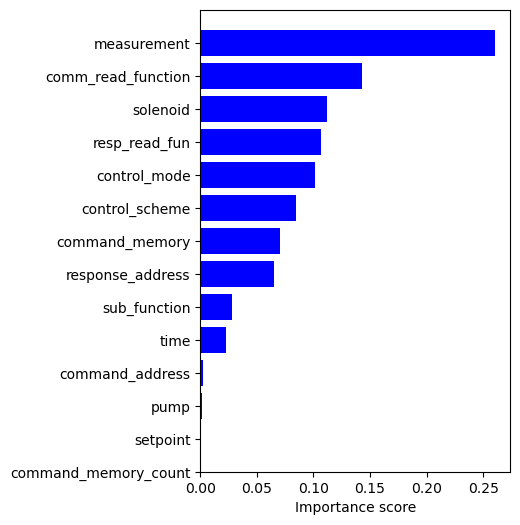

In [17]:
import matplotlib.pyplot as plt

features = list(list_labels)
features.remove('result')

feat_importances = clf_partial.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(4, 6))
plt.xlabel("Importance score")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])

# Top 25 features
plt.ylim([len(feat_importances) - NUM_FEATURES, len(feat_importances)])
plt.show()

In [5]:
explainability_matrix , masks = clf_partial.explain(X_test)

normalized_explain_mat = np.divide(explainability_matrix, explainability_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

explain_and_preds = normalized_explain_mat

## Local interpretability

In [6]:
idx = 0

sample = X_test[idx]
data = {col: [val] for col, val in zip(features, sample)}

i = NUM_FEATURES - 1
while i >= 0:
    print("{:>30}: {}".format(features[i], round(sample[i], 4)))
    i -= 1


                          time: 0.9813
                   measurement: 0.3682
                      solenoid: 0.0
                          pump: 0.0
                control_scheme: 1.0
                  control_mode: 0.0
                      setpoint: 0.0
                  sub_function: 0.0
                 resp_read_fun: 1.0
            comm_read_function: 0.1579
          command_memory_count: 1.0
                command_memory: 0.712
              response_address: 1.0
               command_address: 0.0122


In [7]:
y_test[idx]

0

[0.         0.         0.         0.         0.24484349 0.
 0.08917241 0.         0.         0.23124936 0.         0.
 0.43473474 0.        ]


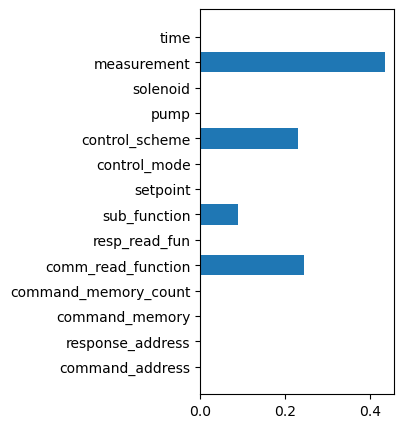

In [21]:
explain_pred = explain_and_preds[idx]
print(explain_pred)

# Plot
plt.figure(figsize=(2.5, 5))
plt.barh(features, explain_pred)
# plt.xticks(rotation=90)

# display the plot
plt.show()